### Extract e mais algumas mudanças de transformação

In [1]:
!pip install pandasql pyspark
!pip install dash pandas plotly

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=4ba5e374b7cbb6491090fe64344aa9b4f19e96200fc35b30befb9df44f7be273
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
import numpy as np
from pyspark.sql import SparkSession
import plotly.express as px

algora = pd.read_csv('algoraquant.csv')
algora['vl_valor'] = algora['vl_valor'].fillna(0)
algora['vl_vpa'] = algora['vl_vpa'].fillna(0)

import pandas as pd


# Função para calcular o novo valor
def calcular_valor_normal(row):
    # Limpa e formata 'vl_vpa' antes de converter para float
    vpa_str = str(row['vl_vpa']).replace('.', '').replace(',', '.').strip()  # Remove milhar e converte decimal
    try:
        vpa = float(vpa_str)  # Converte para float
    except ValueError:
        return None  # Retorna None se a conversão falhar

    # Remove o '%' e substitui a vírgula por ponto, depois converte para float
    variacao = float(row['vl_valor'].replace('%', '').replace(',', '.'))

    # Calcula o novo valor
    novo_valor = vpa * (1 + variacao / 100)
    return novo_valor

# Filtra as linhas onde 'vl_valor' contém '%'
filtro_percentual = algora['vl_valor'].str.contains('%', na=False)

# Aplica o cálculo apenas para essas linhas
algora.loc[filtro_percentual, 'vl_valor'] = algora.loc[filtro_percentual].apply(calcular_valor_normal, axis=1)

import numpy as np

def clean_patrimonio(value):
    if pd.isnull(value) or value == 'NaN':
        return 0  # Mantém como NaN para tratar depois

    value = str(value).replace('.', '').replace(',', '.')  # Normaliza ponto e vírgula
    if '%' in value:  # Se houver porcentagem, retorna 0
        return 0

    value = value.replace('$', '')  # Remove o cifrão se existir

    try:
        return float(value)  # Converte para float
    except ValueError:
        return np.nan  # Se não puder ser convertido, retorna NaN


# Aplicando a função na coluna 'vl_patrimonio'
algora['vl_patrimonio'] = algora['vl_patrimonio'].apply(clean_patrimonio)

# Verificando o resultado após a limpeza

# Calculando a média excluindo valores iguais a 0
mean_value_excluding_zero = algora[algora['vl_patrimonio'] != 0]['vl_patrimonio'].mean()

# Substituindo os valores 0 pela média calculada
algora['vl_patrimonio'] = algora['vl_patrimonio'].replace(0, mean_value_excluding_zero)

import pandas as pd

# Supondo que você já tem o DataFrame 'algora'

# Lista de colunas para as quais queremos aplicar a conversão
colunas_para_convertir = [
    'vl_avaliacao_media_ativos_fundo', 'vl_quantidade_imoveis', 'vl_valor',
    'vl_liquidez_media_diaria', 'vl_pvp', 'vl_dividendo', 'vl_yeld',
    'vl_soma_yield_3m', 'vl_soma_yield_6m', 'vl_soma_yield_12m',
    'vl_media_yield_3m', 'vl_media_yield_6m', 'vl_media_yield_12m',
    'vl_soma_yield_ano_corrente', 'vl_variacao_cotacao_mes', 'vl_rentabilidade_mes',
    'vl_rentabilidade', 'vl_patrimonio', 'vl_vpa', 'vl_pvpa', 'vl_vpa_yield',
    'vl_vpa_change', 'vl_vpa_rent_m', 'vl_vpa_rent', 'vl_ativos',
    'vl_volatility', 'vl_numero_cotista', 'vl_vacancia_fisica', 'vl_vacancia_financeira'
]

# Função para converter a coluna para float
def converter_para_float(coluna):
    try:
        # Remove os pontos (separadores de milhar)
        coluna = coluna.str.replace('.', '', regex=False)
        # Substitui a vírgula por ponto (separador decimal)
        coluna = coluna.str.replace(',', '.', regex=False)
        # Converte para float
        return coluna.astype(float)
    except Exception as e:
        return coluna  # Retorna a coluna original em caso de erro

# Aplica a conversão para cada coluna na lista
for coluna in colunas_para_convertir:
    if coluna in algora.columns:
        algora[coluna] = converter_para_float(algora[coluna])



Pronto estamos prontos para começar as nossas análises exploratórias, aqui deixamos apenas valores decimais facieís de serem tratados,
ou seja ... que não nenhum tipo de porcentagem envolvido, ficando cerca de 10 colunas de valores a serem análisados de acordo com a estatística

In [4]:
algora = algora.drop(columns=['Unnamed: 0','valor_decimal', 'vl_vpa_rent','vl_vpa_rent_m','vl_vpa_change','vl_vpa_yield','vl_pvpa','vl_rentabilidade',
                              'vl_rentabilidade_mes','vl_variacao_cotacao_mes','vl_soma_yield_ano_corrente','vl_yeld', 'vl_soma_yield_3m',
                              'vl_soma_yield_6m', 'vl_soma_yield_12m','vl_ativos', 'vl_media_yield_3m', 'vl_media_yield_6m', 'vl_media_yield_12m','vl_vacancia_financeira','vl_vacancia_fisica'])
# prenchendo os outros títulos com os valores de Humanidade

categoria_renomeacao = {
    'Shopping':'Tijolo Comercial',
    'Shoppings': 'Tijolo Comercial',
    #'Lajes Corporativas': 'Tijolo Comercial',
    'Imóveis Comerciais - Outros': 'Tijolo Comercial',
    #'Agências de Bancos': 'Tijolo Comercial',
    'Varejo': 'Tijolo Comercial',
    'Imóveis Industriais e Logísticos': 'Tijolo Logístico/Industrial',
    'Logística': 'Tijolo Logístico/Industrial',
    'Imóveis Residenciais': 'Tijolo Comercial',
    'Residencial': 'Tijolo Comercial',
    'Papéis': 'Papel',
    'Títulos e Val. Mob.': 'Papel',
    'Títulos e Valores Mobiliários': 'Papel',
    'Fundo de Fundos': 'Híbrido',
    'Misto': 'Híbrido',
    'Híbrido': 'Híbrido',
    'Fundo de Desenvolvimento': 'Desenvolvimento',
    'Incorporações': 'Desenvolvimento',
    'Hotéis': 'Hotel',
    #'Hotel': 'Tijolo Comercial',
    'Serviços Financeiros Diversos': 'Setor Específico',
    'Educacional': 'Setor Específico',
    'Hospitalar': 'Setor Específico',
    'Hospital': 'Setor Específico',
    'Fiagro': 'Setor Específico',
    'Agricultura': 'Setor Específico',
    'Indefinido': 'Indefinido',
    'Indefinido2016': 'Indefinido',
    'Indefinido2015': 'Indefinido',
    'Indefinido2017': 'Indefinido',
    'Renda': 'Renda'
}

# Aplicando a renomeação no DataFrame 'algora'
algora['nm_setor'] = algora['nm_setor'].replace(categoria_renomeacao)

numeric_columns = ['vl_media_taxa_homicidios', 'vl_avaliacao_media_ativos_fundo', 'vl_quantidade_imoveis']

# Aplicamos o 'groupby' apenas nas colunas numéricas
algora[numeric_columns] = algora.groupby('nm_titulo')[numeric_columns].transform(lambda x: x.fillna(x.mean()))

algora['dt_inclusao'] = pd.to_datetime(algora['dt_inclusao'])

nm_titulo
0	CPTS11B
1	FIXX11
2	RBBV11
3	BZLI11
4	UBSR11
5	OUCY11
6	FOFT11
7	AFOF11
8	IFIE11
9	RBIV11
10	IFID11
11	QIFF11
12	EQIN11
13	ATSA11B
14	WPLZ11B
15	FIVN11
16	HMOC11
17	DMAC11
18	GRLV11
19	TRXL11
20	HGJH11
21	DOMC11
22	TBOF11
23	BBVJ11
24	BMLC11B
25	FFCI11
26	RDES11
27	FVBI11


Fundos que não existem ou pararam de existir ao longo dos anos ... 2016 até 202428	THRA11
29	GWIR11
30	AFCR11

### Distribuição de Dados Categóricas do Banco de Dados - FII - Correlação

In [5]:
import ipywidgets as widgets
import pandasql as ps
import pandas as pd


# Lista de categorias disponíveis
categorias = ['Indefinido', 'Tijolo Comercial', 'Papel', 'Outros',
       'Lajes Corporativas', 'Híbrido', 'Tijolo Logístico/Industrial',
       'Setor Específico', 'Agências de Bancos', 'Desenvolvimento',
       'Hotel', 'Renda']


# Função que executa a query com base na seleção
def executar_query(categoria,dataframe):
    query = f"""
    SELECT *
    FROM algora
    WHERE
      dt_inclusao > '2021-08-15'
      AND TRIM(nm_setor) IN ('{categoria}')
    ORDER BY dt_inclusao DESC
    """

    # Executa a query usando pandasql
    gora = ps.sqldf(query, {"algora": dataframe})

    # Preenchendo valores nulos e ajustando a coluna 'vl_patrimonio'
    mean_value_excluding_zero = gora[gora['vl_patrimonio'] != 0]['vl_patrimonio'].mean()
    gora['vl_patrimonio'] = gora['vl_patrimonio'].fillna(0)
    gora['vl_patrimonio'] = gora['vl_patrimonio'].replace(0, mean_value_excluding_zero)

    # Exibe o número de linhas e colunas e descrição do DataFrame
    print(f"Temos {gora.shape[0]} linhas e {gora.shape[1]} colunas")

    # Obter a primeira e última data
    primeira_data = gora['dt_inclusao'].min()
    ultima_data = gora['dt_inclusao'].max()

    # Exibir os resultados
    print(f"A primeira data é: {primeira_data}")
    print(f"A última data é: {ultima_data}")

    return gora

cat = categorias[1]

# Executando a query inicial com o valor padrão
gora = executar_query(cat, algora)

gora_numeric = gora.drop(['nm_titulo','nm_setor','dt_inclusao'], axis = 1)

import plotly.express as px

# Gera a matriz de correlação
correlation_matrix = gora_numeric.corr()

# Criando o gráfico de correlação com limites ajustados de -1 a 1
fig = px.imshow(correlation_matrix,
                text_auto=True,
                zmin=-1, zmax=1,  # Define os limites de -1 a 1
                color_continuous_scale='RdBu')  # Usa uma escala de cores adequada

# Adicionar a anotação
fig.add_annotation(
    text=f'Categoria: {cat.lower()}',  # O texto que você quer adicionar
    xref="paper", yref="paper",  # Referência em relação ao espaço do gráfico
    x=0.5, y=1.1,  # Posição (0.5 é o meio da largura, 1.1 é acima do gráfico)
    showarrow=False,  # Não mostra uma seta
    font=dict(size=14, color="black")  # Configurações de fonte
)

# Exibir o gráfico
fig.show()



Temos 523 linhas e 14 colunas
A primeira data é: 2021-10-01 00:00:00.000000
A última data é: 2024-09-01 00:00:00.000000


### Linha do Tempo Simplificada:

- **2016 - 2018**: Recuperação econômica lenta após recessão, juros elevados, FIIs em expansão inicial.
- **Junho de 2019**: Corte agressivo da Selic, cenário favorável para os FIIs.
- **2020 - 2021**: Pandemia de COVID-19 causa volatilidade, especialmente em FIIs de shoppings e escritórios.
- **2022 - 2024**: Retomada do mercado, elevação da Selic impacta o retorno dos FIIs, mas setores como logística e recebíveis ganham força.


### Modelo de Clusterização - Executar em Ambiente em Nuvem ou em PC Externo

In [ ]:
from pyspark.sql import SparkSession

# Cria a sessão Spark com configurações ajustadas

spark = SparkSession.builder\
  .appName('recomendador FII pySpark')\
  .getOrCreate()


In [ ]:
from pyspark.sql import functions as F

numeric_columns = [
    'vl_media_taxa_homicidios',
    'vl_avaliacao_media_ativos_fundo',
    'vl_quantidade_imoveis',
    'vl_valor',
    'vl_liquidez_media_diaria',
    'vl_pvp',
    'vl_dividendo',
    'vl_patrimonio',
    'vl_vpa',
    'vl_volatility',
    'vl_numero_cotista'
]

# Substituir os NaNs por 0 nas colunas numéricas
gora_spark = spark.createDataFrame(gora).na.fill(0, subset=numeric_columns)


aggregated_data = gora_spark.groupBy('nm_titulo').agg(
    F.mean('vl_media_taxa_homicidios').alias('mean_vl_media_taxa_homicidios'),
    F.mean('vl_avaliacao_media_ativos_fundo').alias('mean_vl_avaliacao_media_ativos_fundo'),
    F.mean('vl_quantidade_imoveis').alias('mean_vl_quantidade_imoveis'),
    F.mean('vl_valor').alias('mean_vl_valor'),
    F.mean('vl_liquidez_media_diaria').alias('mean_vl_liquidez_media_diaria'),
    F.mean('vl_pvp').alias('mean_vl_pvp'),
    F.mean('vl_dividendo').alias('mean_vl_dividendo'),
    F.mean('vl_patrimonio').alias('mean_vl_patrimonio'),
    F.mean('vl_vpa').alias('mean_vl_vpa'),
    F.mean('vl_volatility').alias('mean_vl_volatility'),
    F.mean('vl_numero_cotista').alias('mean_vl_numero_cotista')
)

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

def cria_pipeline_kmeans_cluster(aggregated_data):
    seed = 1224


    # Passo 2: Seleção das Features
    feature_columns = [
        'mean_vl_media_taxa_homicidios',
        'mean_vl_avaliacao_media_ativos_fundo',
        'mean_vl_quantidade_imoveis',
        'mean_vl_valor',
        'mean_vl_liquidez_media_diaria',
        'mean_vl_pvp',
        'mean_vl_dividendo',
        'mean_vl_patrimonio',
        'mean_vl_vpa',
        'mean_vl_volatility',
        'mean_vl_numero_cotista'
    ]

    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

    # Passo 3: Escalonamento
    scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

    # Passo 4: PCA (opcional, pode ser útil para visualizar em 2D, mas pode não ser necessário para clustering)
    pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')

    # Passo 5: KMeans
    kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster').setK(7).setSeed(seed)

    # Construção do Pipeline
    pipeline = Pipeline(stages=[assembler, scaler,pca, kmeans])

    # Treinamento do Pipeline
    pipeline_model = pipeline.fit(aggregated_data)

    # Aplicação do Pipeline
    predictions = pipeline_model.transform(aggregated_data)

    # Extração das Features PCA para Visualização
    from pyspark.ml.functions import vector_to_array
    pca_feature_xy = predictions.withColumn('x', vector_to_array('pca_features')[0])\
                                .withColumn('y', vector_to_array('pca_features')[1])\
                                .select(['x', 'y', 'cluster', 'nm_titulo'])

    # Visualização com Plotly
    import plotly.express as px
    fig = px.scatter(pca_feature_xy.toPandas(), x='x', y='y', color='cluster',
                     hover_data=['nm_titulo'])
    fig.show()

    return pipeline_model

In [ ]:
pipeline_model = cria_pipeline_kmeans_cluster(aggregated_data)

### Realizando Trade de FII em um modo conservador com base em netraulidade = 0, vender = -1 e comprar = 1

Quero realizar um estudo em cima de uma estratégia de fundo quantitativo, por exemplo você recebe 100.000 mil reais, e a recomendação através de regressão trabalhará em cima do retorno de dividendos observando as variáveis que temos dentro de nosso Banco de Dados, e você passará para a gente o quanto de tempo que manterá aplicado e no final a aplicação de acordo com os tipos de trades que fez, retornará a quantia que você terá e quanto ganhou em cima das aplicações que o "robo" fez

Também mostraremos os trades em FII que fizemos ao longo de todos os meses, por exemplo a carteira que escolhemos ter: Foi de 5 ativos mais ou menos, comprando ,vendendo e mantendo, dependendo do divendo e riscos que poderíamos ter na aplicação até finalizar este 1 ano realizando os trades.

### BACKTESTING

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Retirando os Nulos e atribuindo o valor "Zero"
gora = gora.fillna(0)

# Separando os dados em treino e teste
train = gora[gora['dt_inclusao'] < '2024-04-01']
test = gora[gora['dt_inclusao'] >= '2024-04-01']

# Features (variáveis explicativas) e Target (o que queremos prever)
X_train = train[['vl_valor','vl_liquidez_media_diaria','vl_dividendo','vl_patrimonio','vl_volatility','vl_numero_cotista']]
y_train = train['vl_dividendo']

X_test = test[['vl_valor','vl_liquidez_media_diaria','vl_dividendo','vl_patrimonio','vl_volatility','vl_numero_cotista']]
y_test = test['vl_dividendo']

# Criando e treinando o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazendo predições no conjunto de teste
y_pred = model.predict(X_test)

# Adicionando as predições ao DataFrame de teste para backtest
test['vl_dividendo_previsto'] = y_pred

# Calculando métricas de desempenho do modelo
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Exibindo as previsões e os valores reais para backtest
resultado = test[['dt_inclusao', 'nm_titulo', 'vl_dividendo', 'vl_dividendo_previsto']]
print("\nResultado do Backtest (Valores Reais x Previstos):")

resultado

#'vl_avaliacao_media_ativos_fundo_lag1','vl_quantidade_imoveis_lag1','vl_valor_lag1','vl_liquidez_media_diaria_lag1','vl_dividendo_lag1','vl_patrimonio_lag1','vl_vpa_lag1','vl_volatility_lag1','vl_numero_cotista_lag1'
# vl_pvp, vl_vpa


R²: 1.0
Mean Squared Error: 6.709332323454459e-18
Mean Absolute Error: 9.539743759909821e-10

Resultado do Backtest (Valores Reais x Previstos):


<ipython-input-6-2f334cfc4610>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,dt_inclusao,nm_titulo,vl_dividendo,vl_dividendo_previsto
0,2024-09-01 00:00:00.000000,ABCP11,0.62,0.62
1,2024-09-01 00:00:00.000000,AJFI11,0.07,0.07
2,2024-09-01 00:00:00.000000,APTO11,0.09,0.09
3,2024-09-01 00:00:00.000000,APXM11,0.54,0.54
4,2024-09-01 00:00:00.000000,ATSA11,0.72,0.72
...,...,...,...,...
131,2024-04-01 00:00:00.000000,VCRR11,0.70,0.70
132,2024-04-01 00:00:00.000000,VISC11,1.00,1.00
133,2024-04-01 00:00:00.000000,VSHO11,0.65,0.65
134,2024-04-01 00:00:00.000000,WPLZ11,0.41,0.41


In [ ]:
resultado.sort_values(by=['nm_titulo'])

,dt_inclusao,nm_titulo,vl_dividendo,vl_dividendo_previsto
0,2024-09-01 00:00:00.000000,ABCP11,0.62,0.62
92,2024-04-01 00:00:00.000000,ABCP11,0.50,0.50
48,2024-06-01 00:00:00.000000,ABCP11,0.50,0.50
1,2024-09-01 00:00:00.000000,AJFI11,0.07,0.07
93,2024-04-01 00:00:00.000000,AJFI11,0.07,0.07
...,...,...,...,...
90,2024-06-01 00:00:00.000000,WPLZ11,0.41,0.41
134,2024-04-01 00:00:00.000000,WPLZ11,0.41,0.41
91,2024-06-01 00:00:00.000000,XPML11,0.90,0.90
47,2024-09-01 00:00:00.000000,XPML11,0.92,0.92


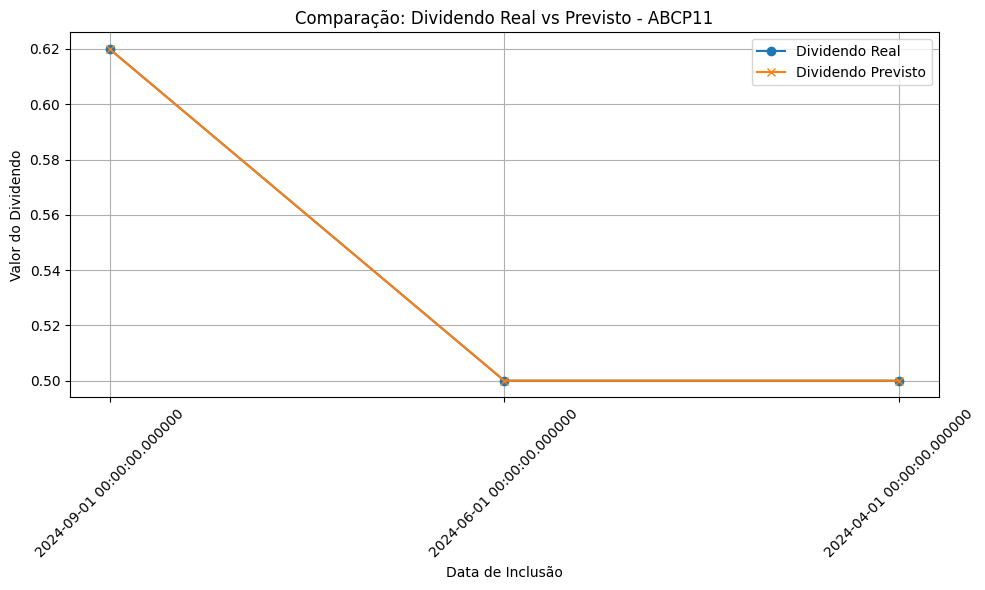

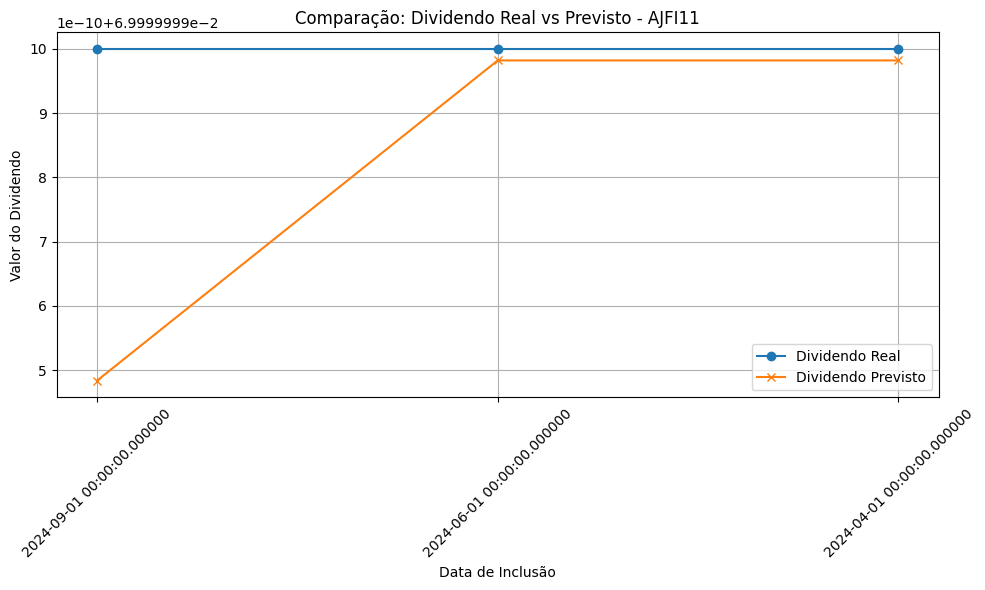

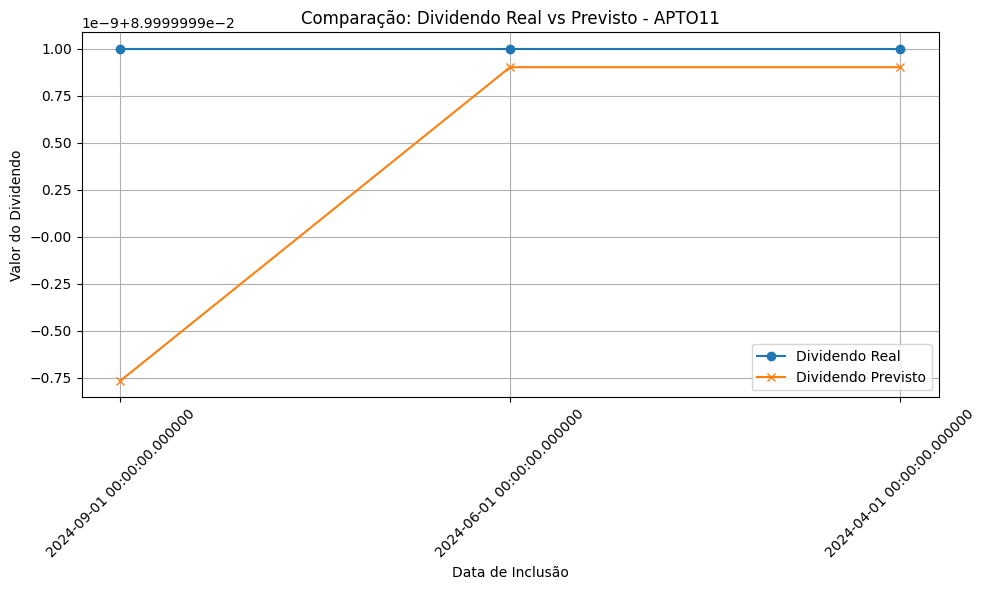

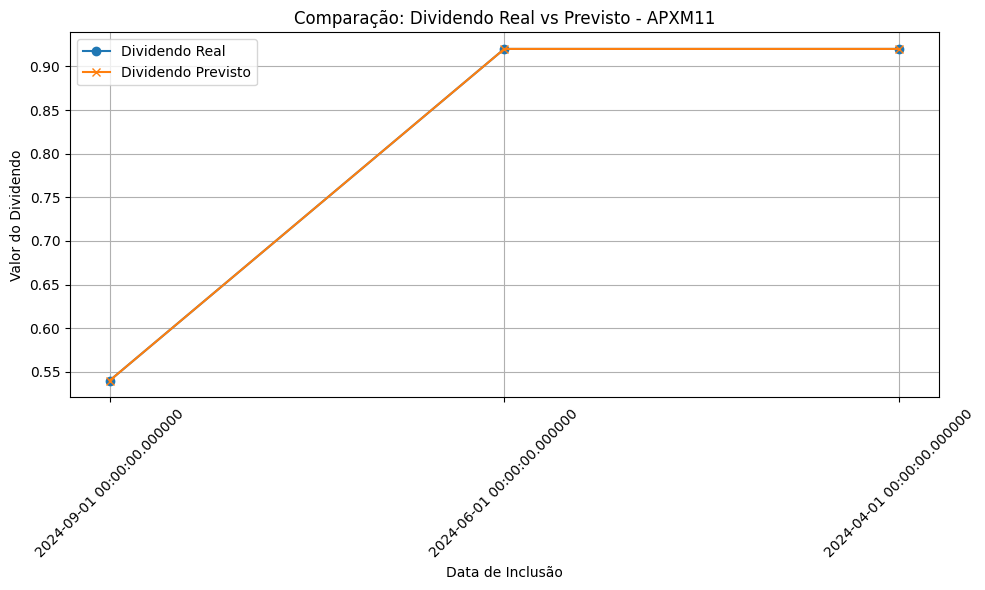

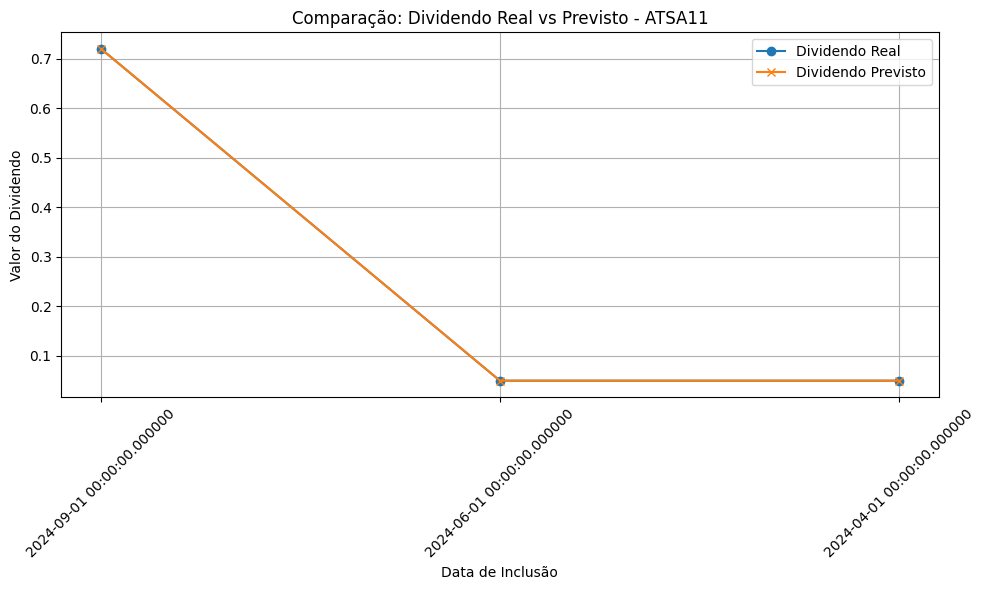

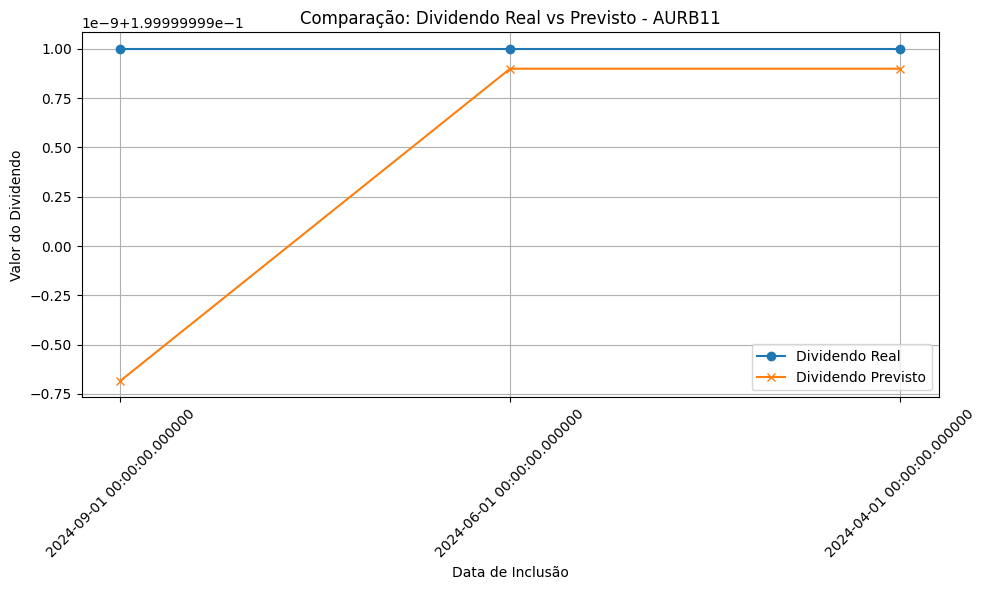

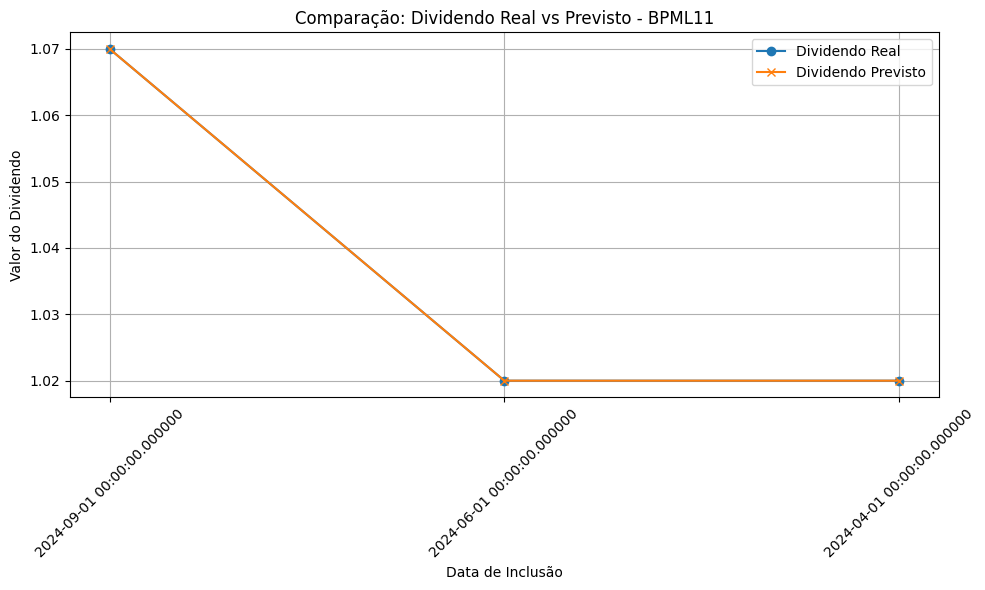

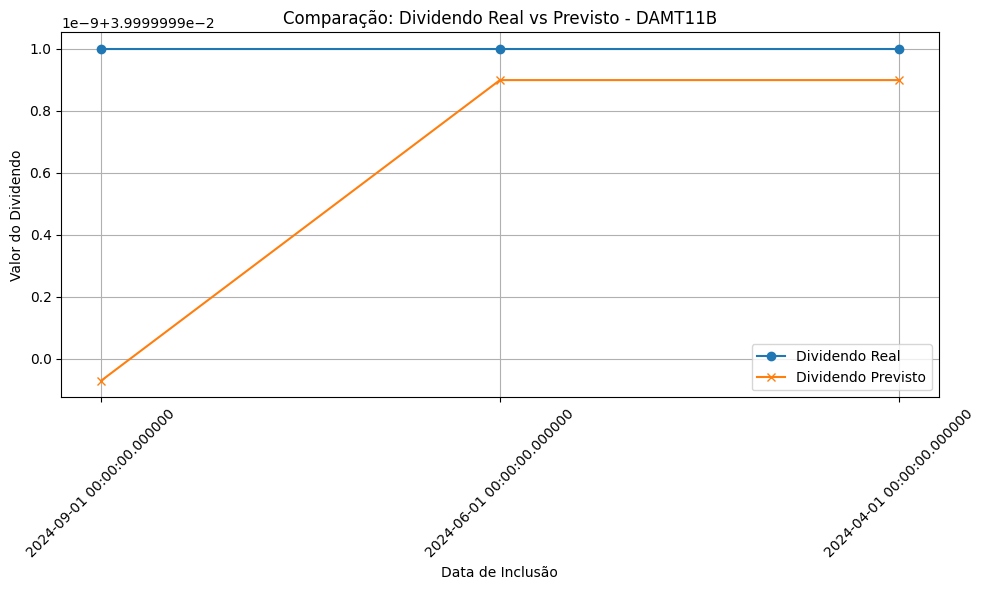

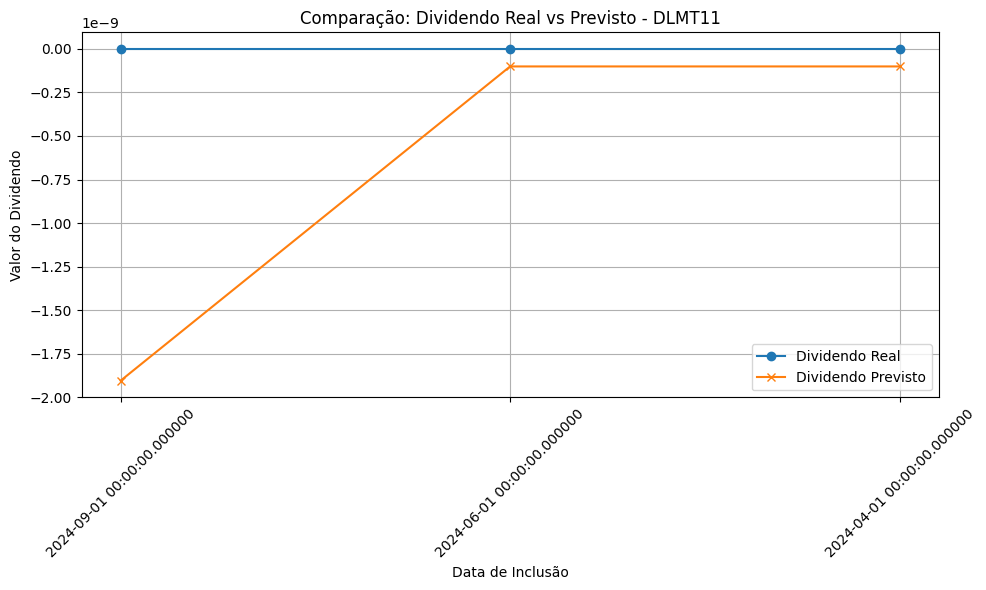

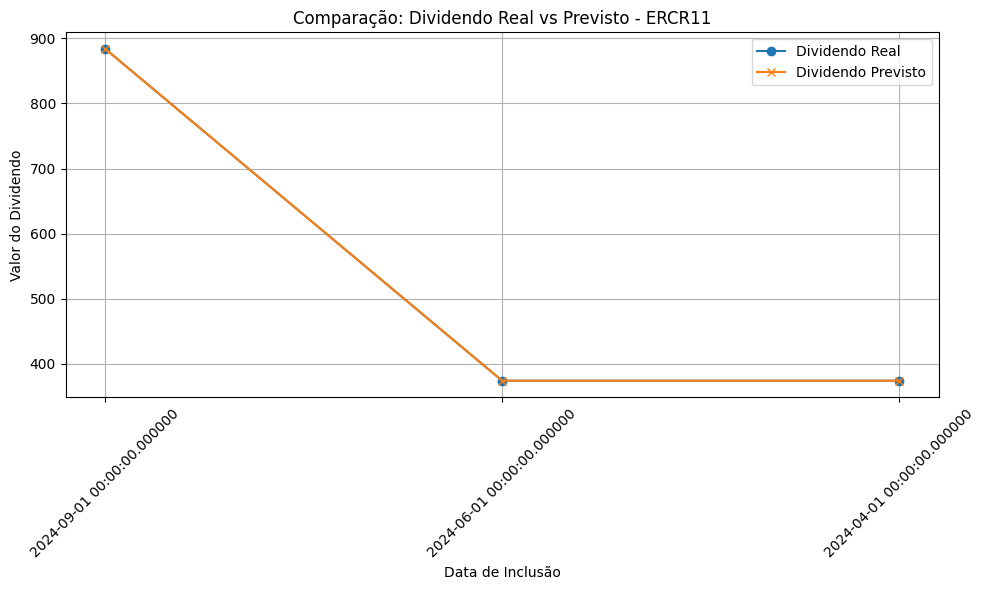

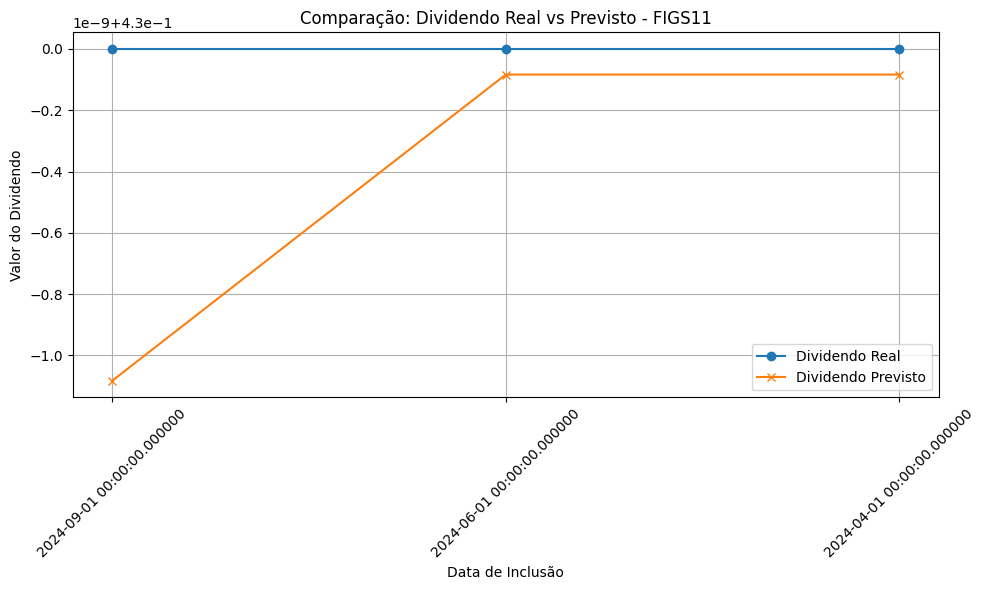

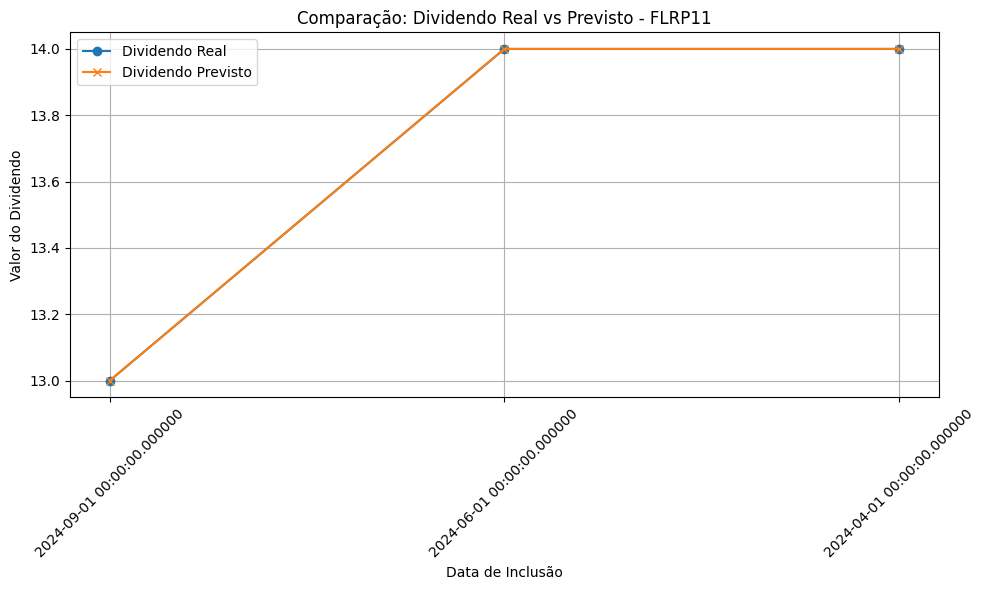

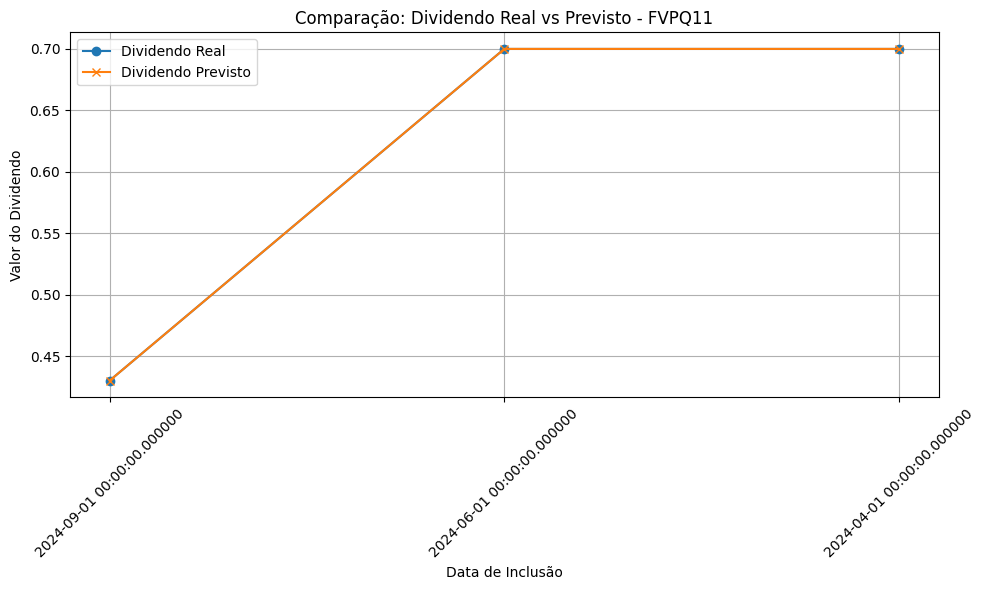

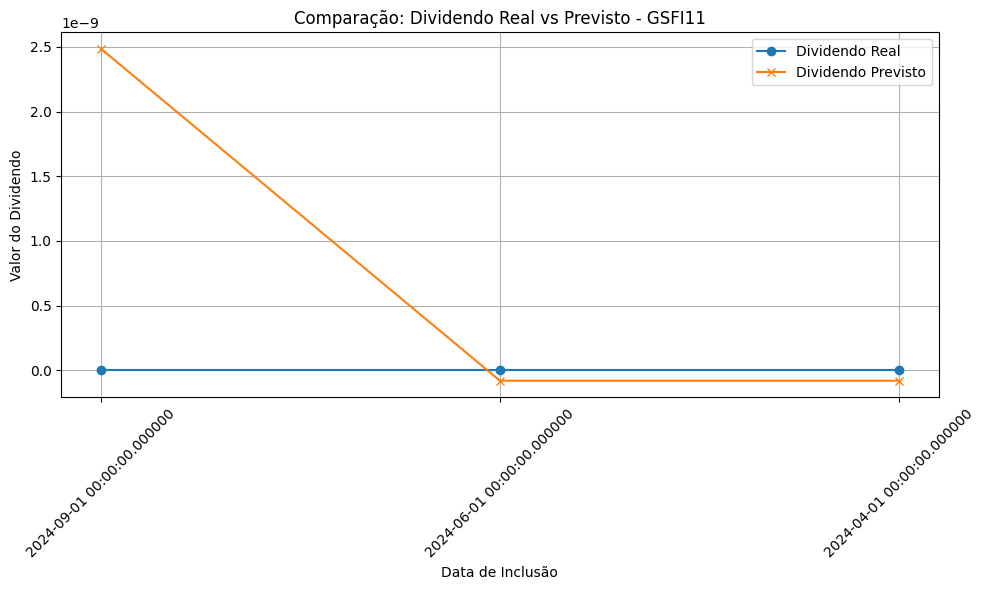

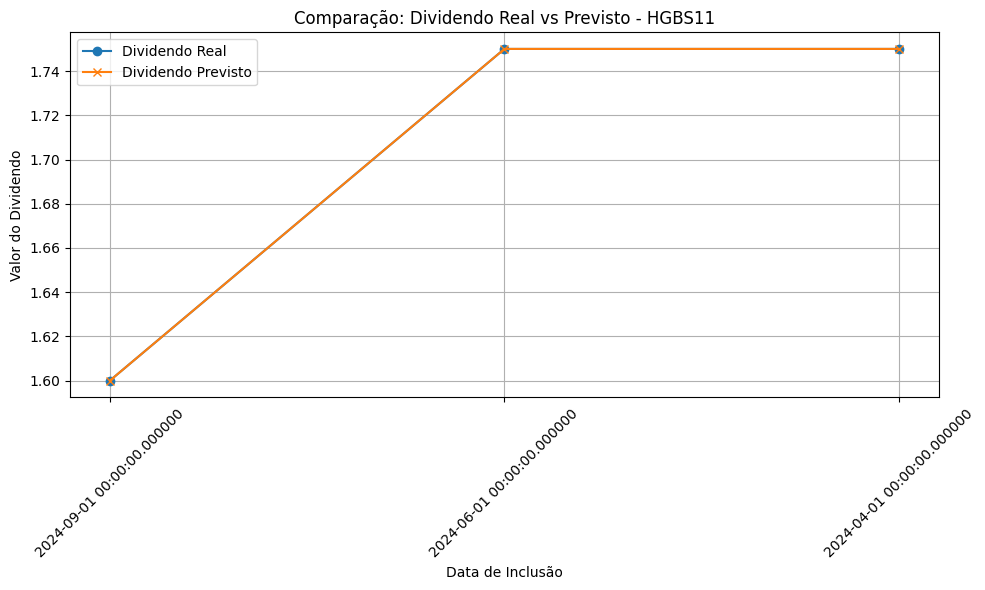

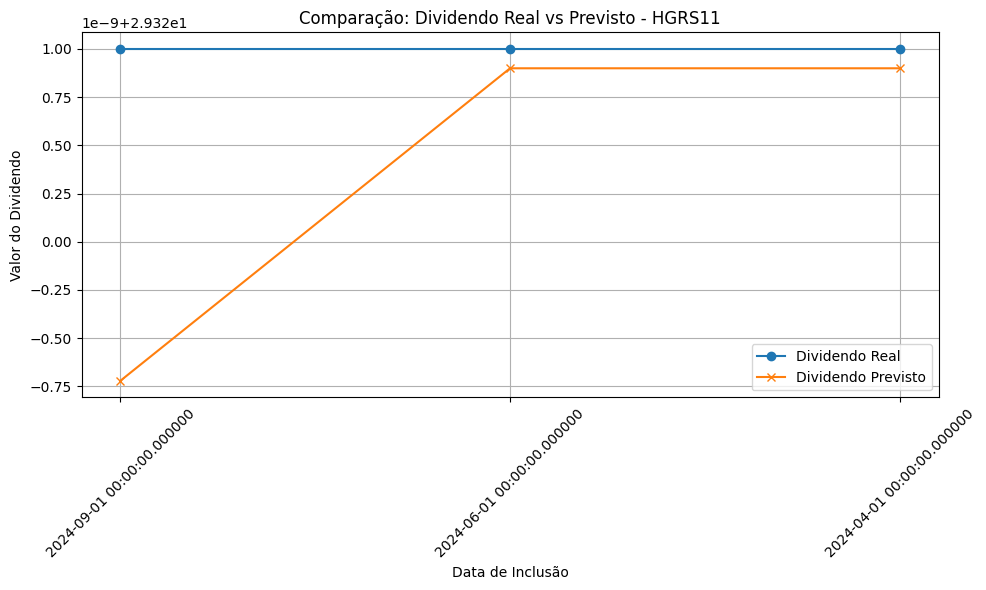

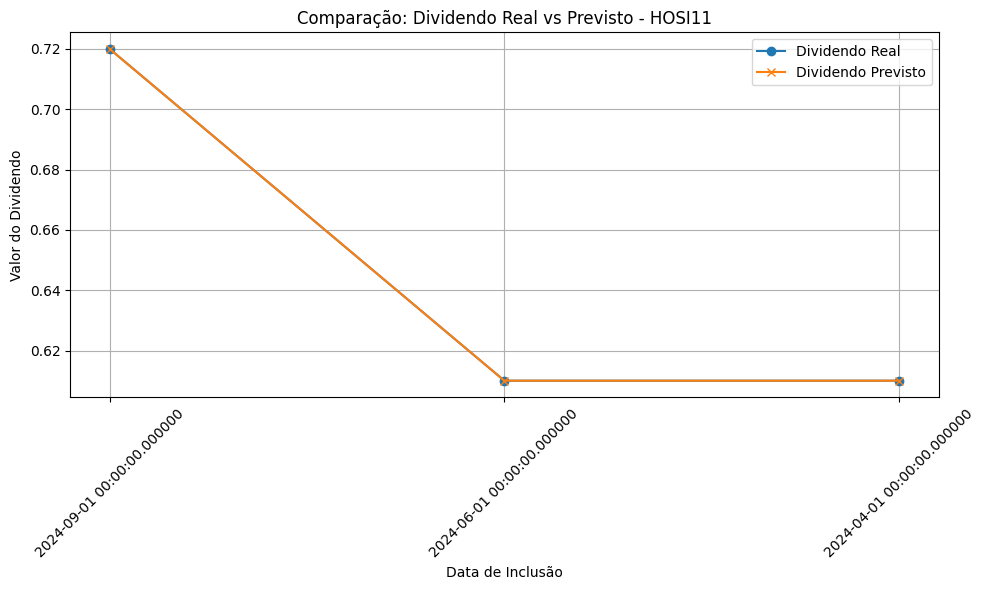

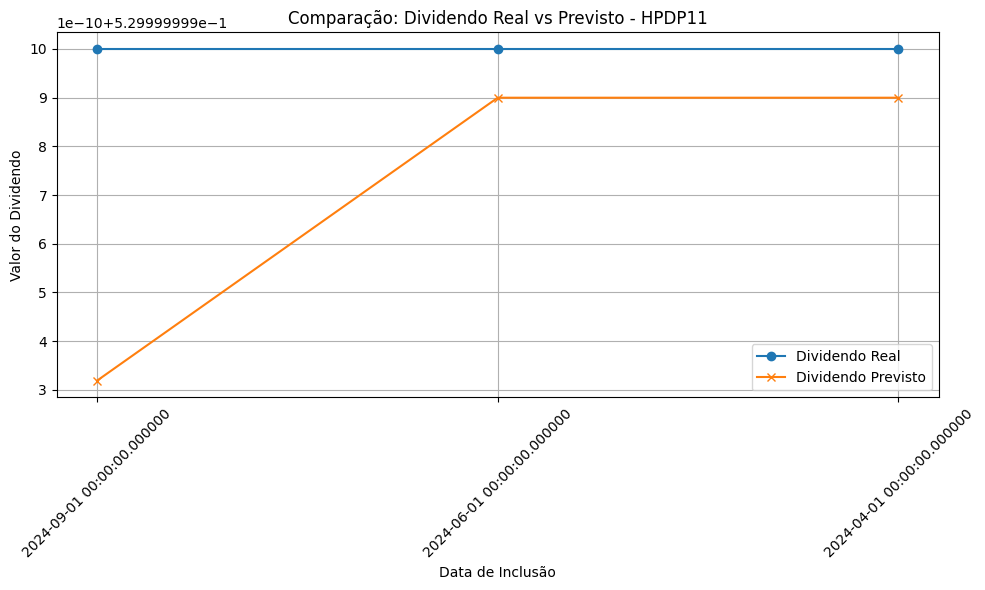

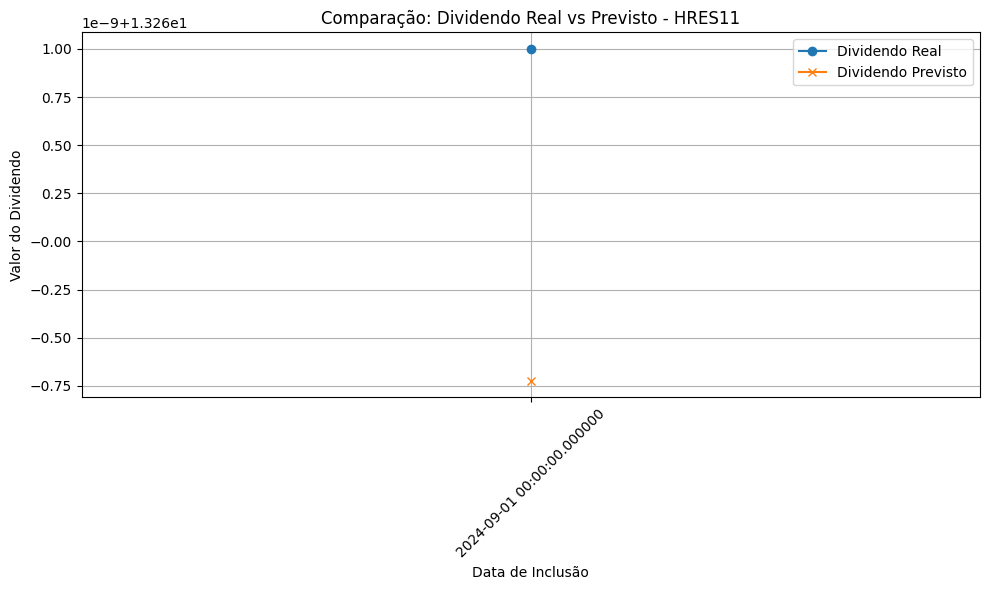

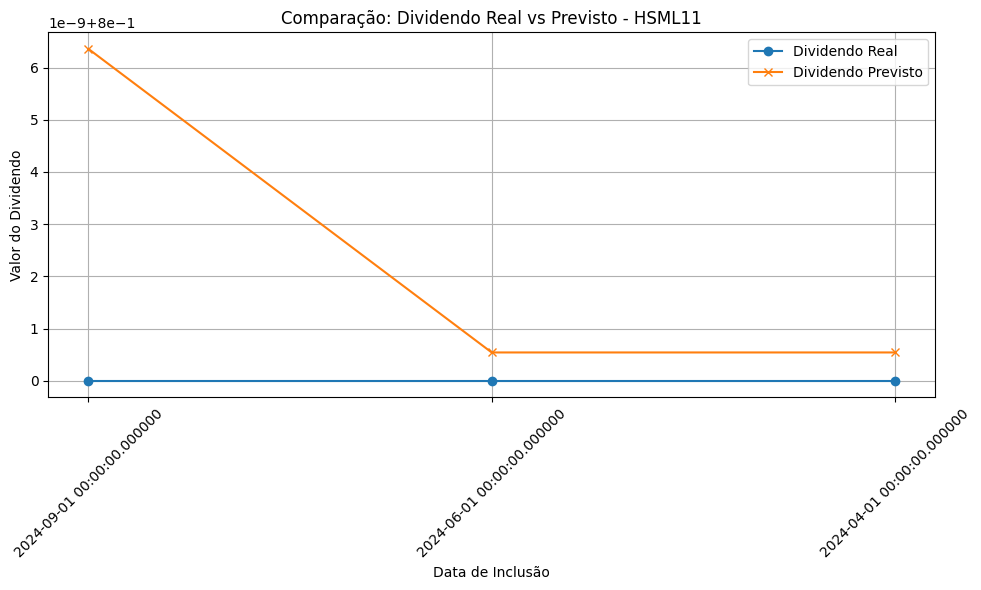

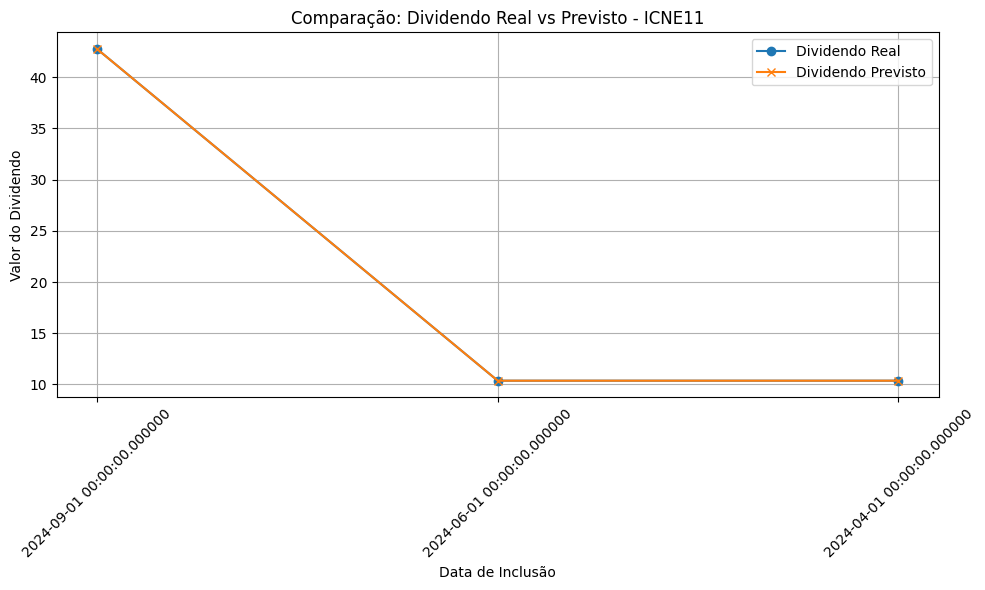

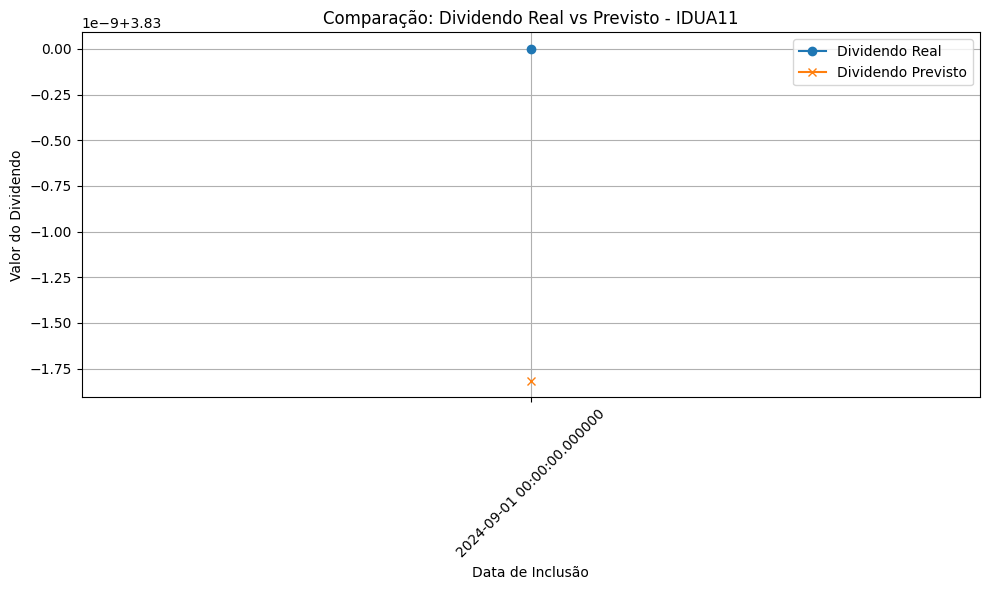

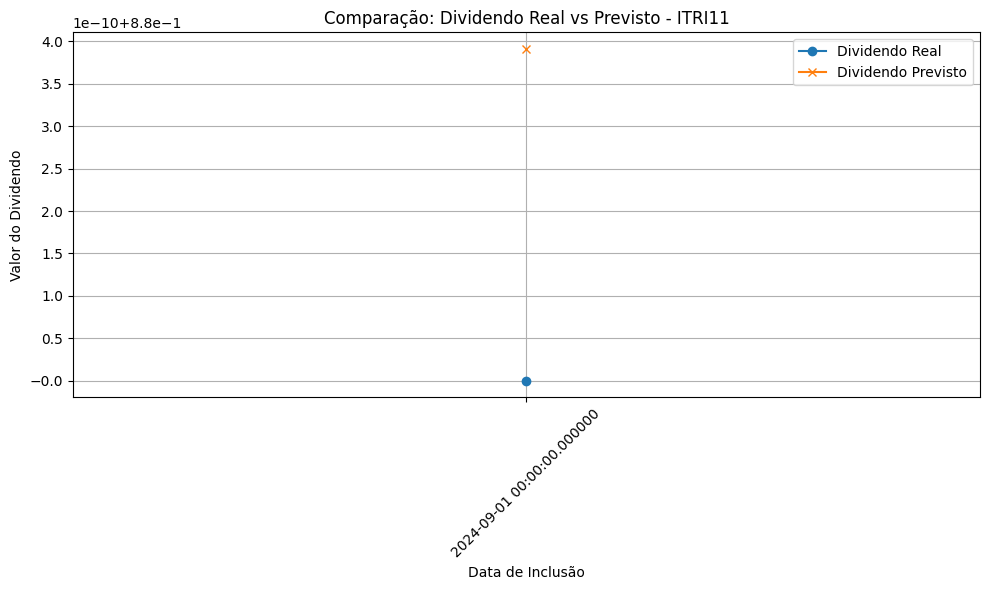

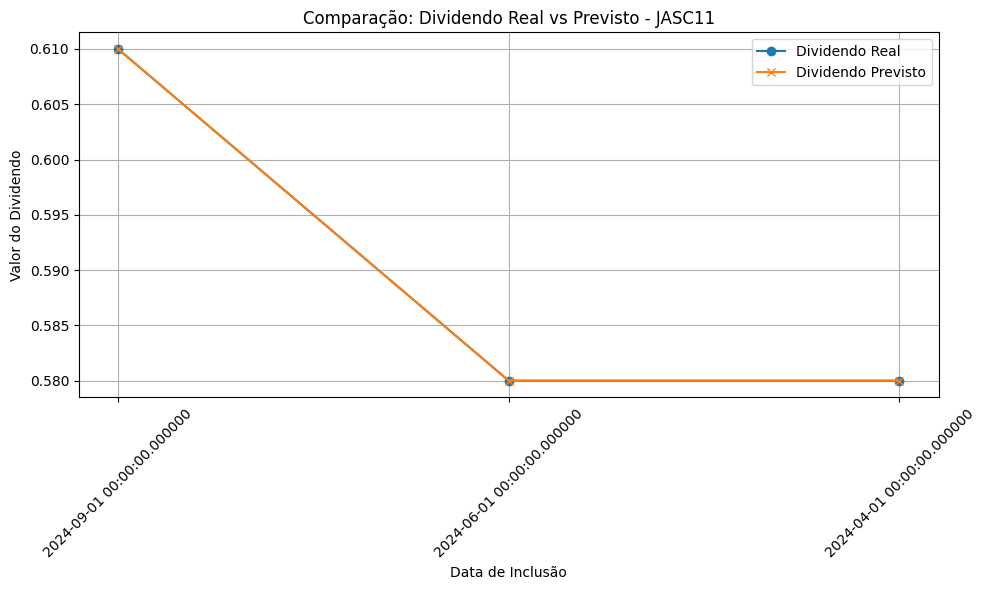

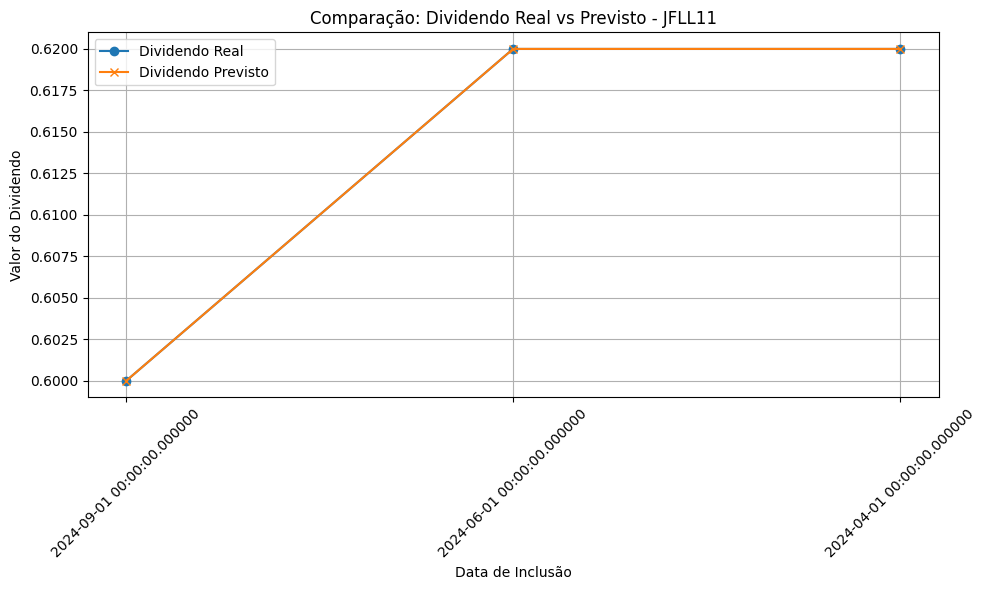

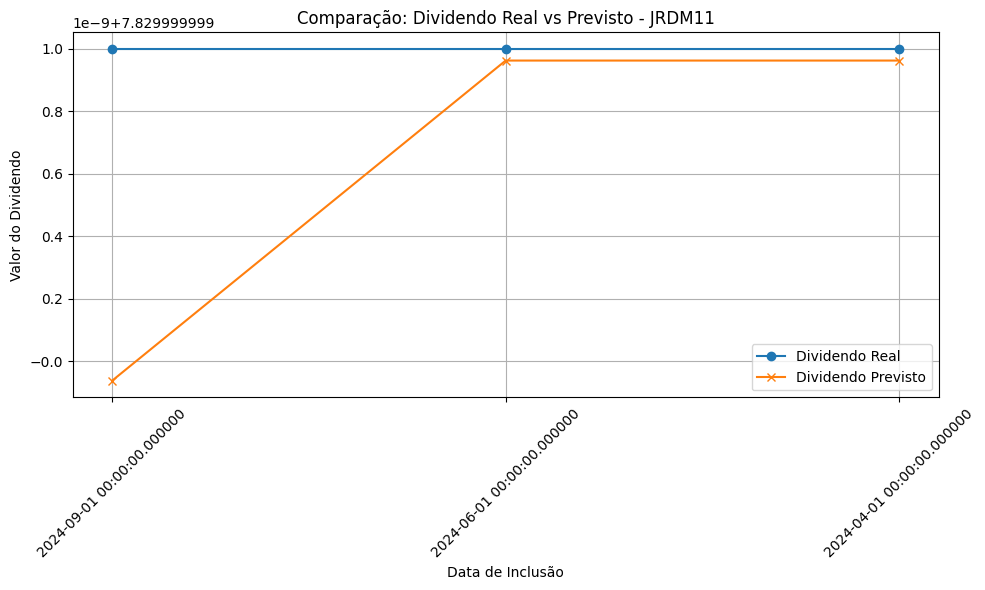

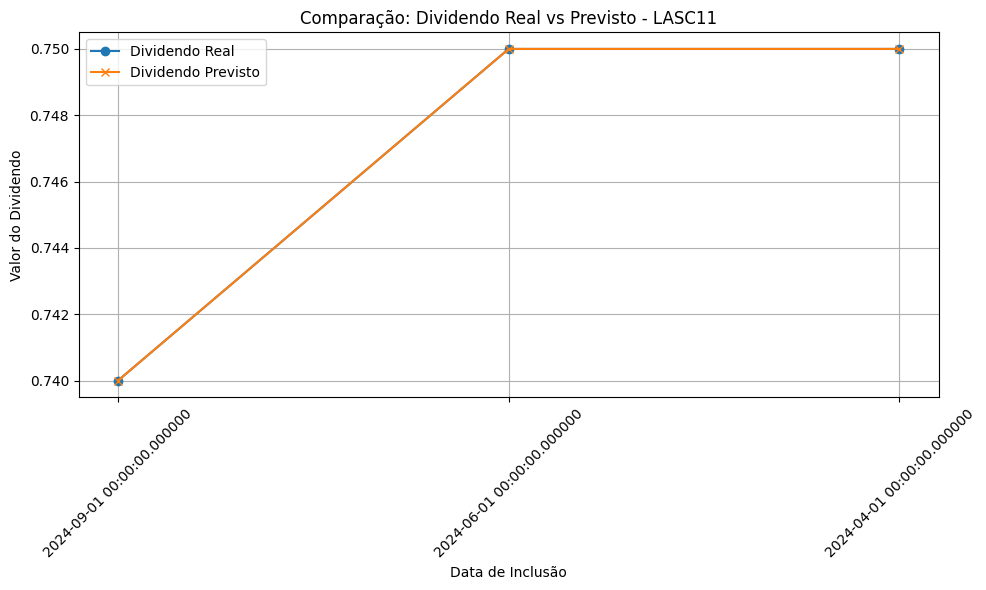

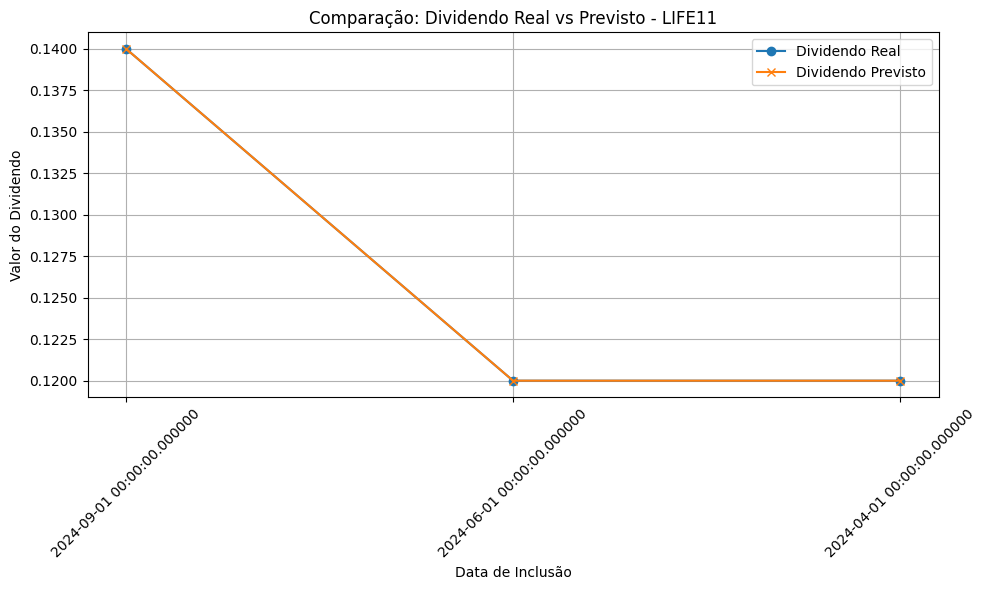

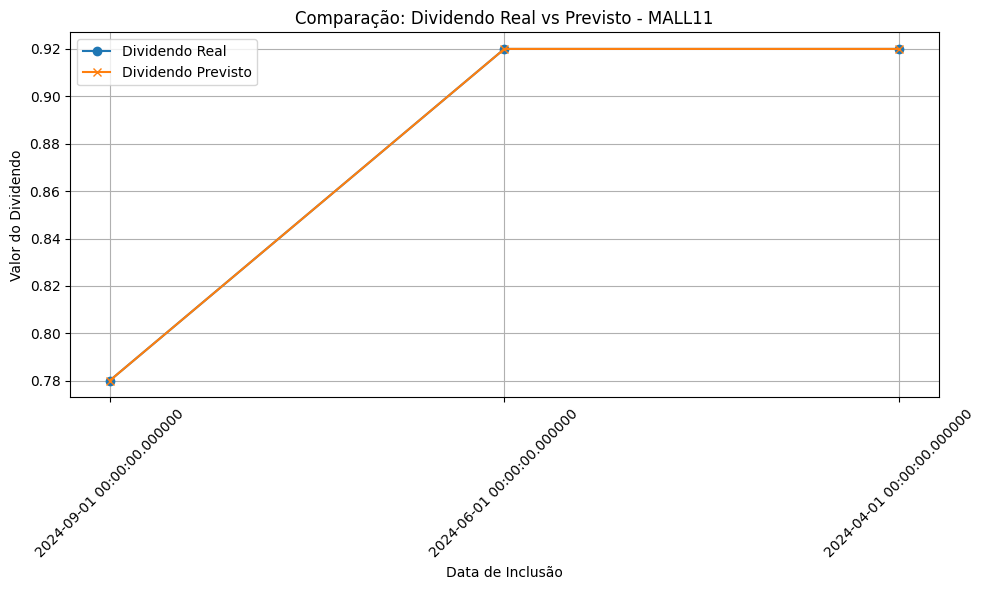

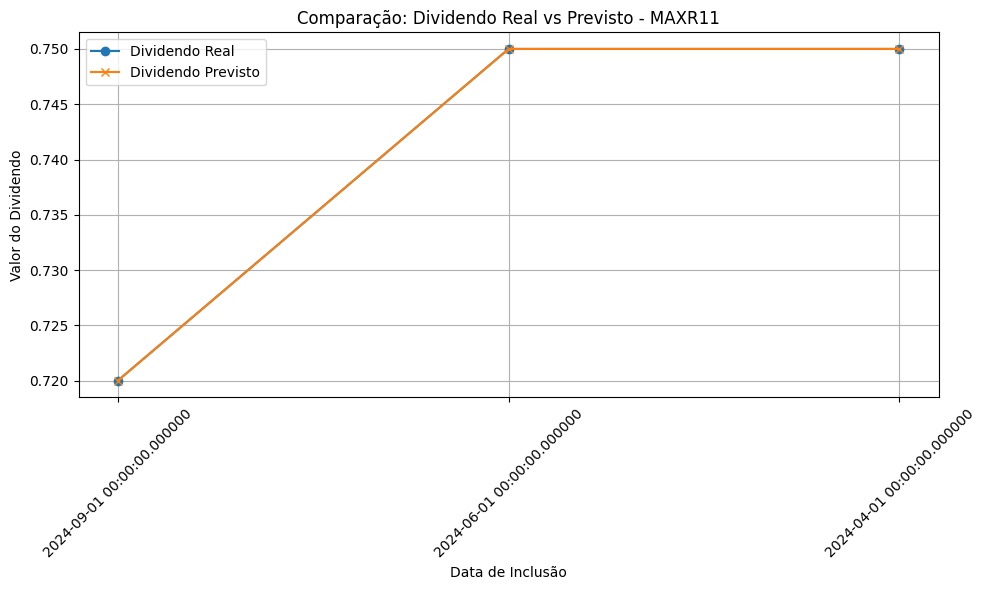

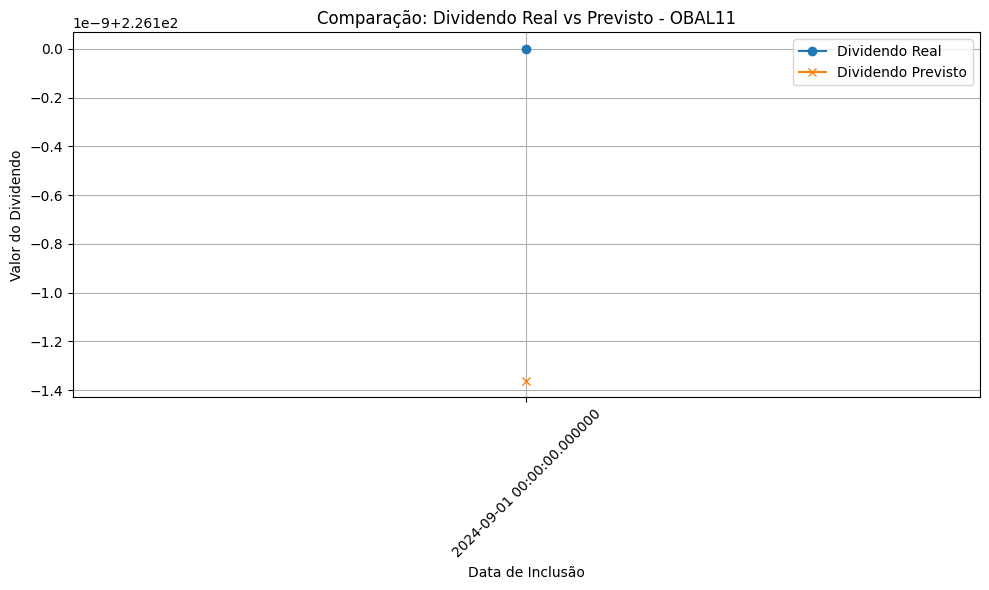

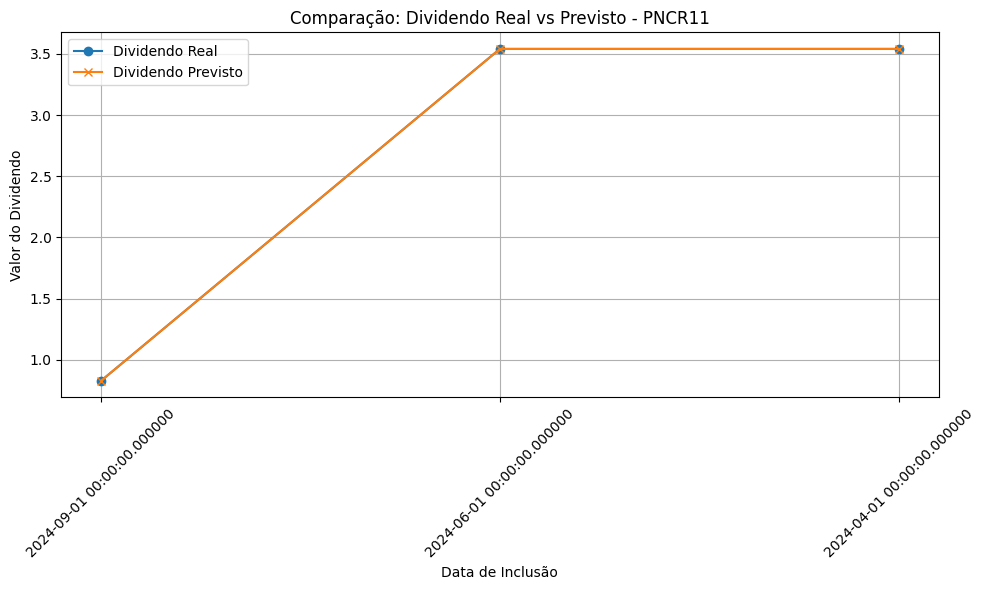

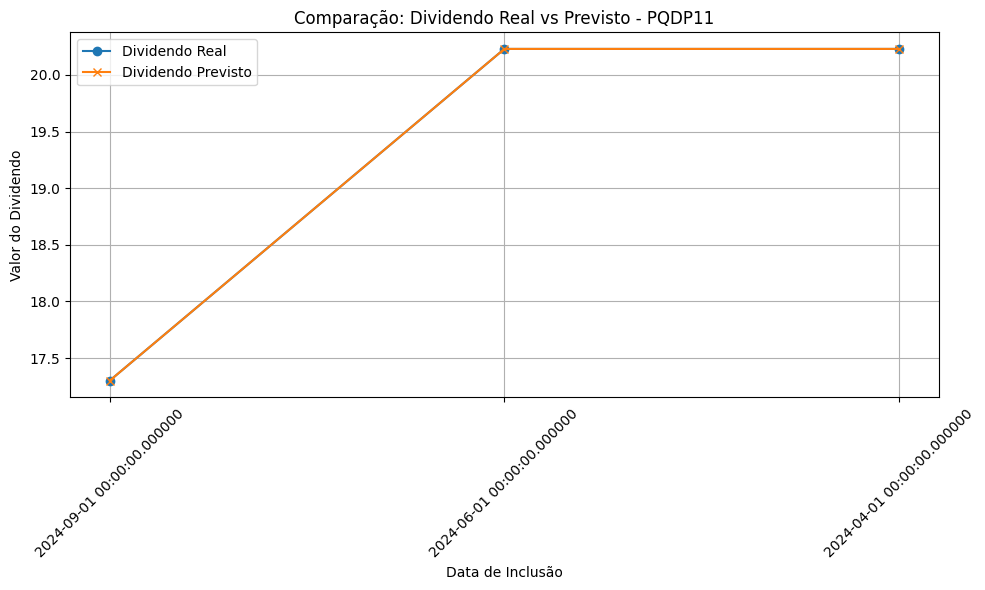

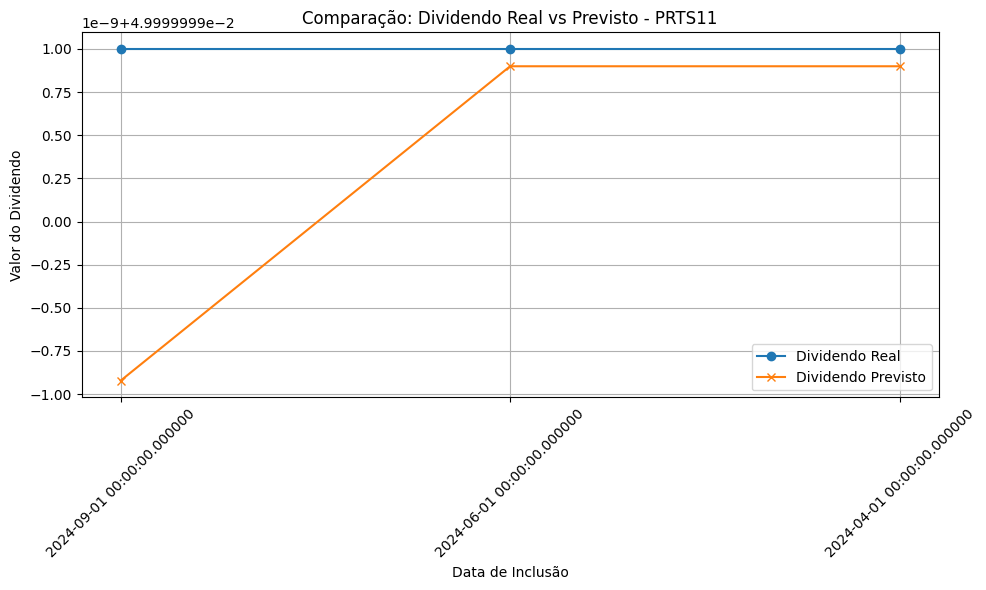

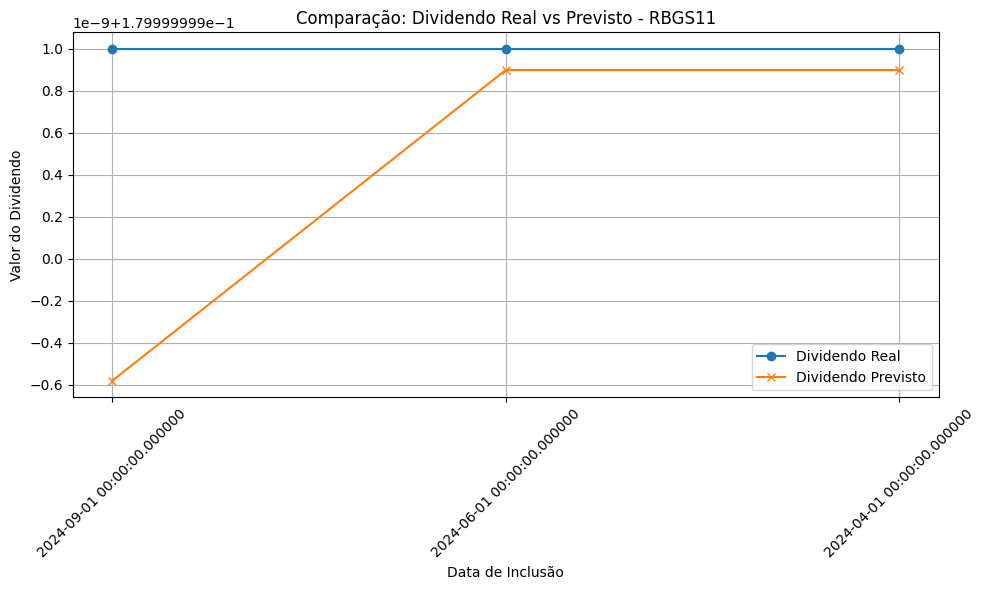

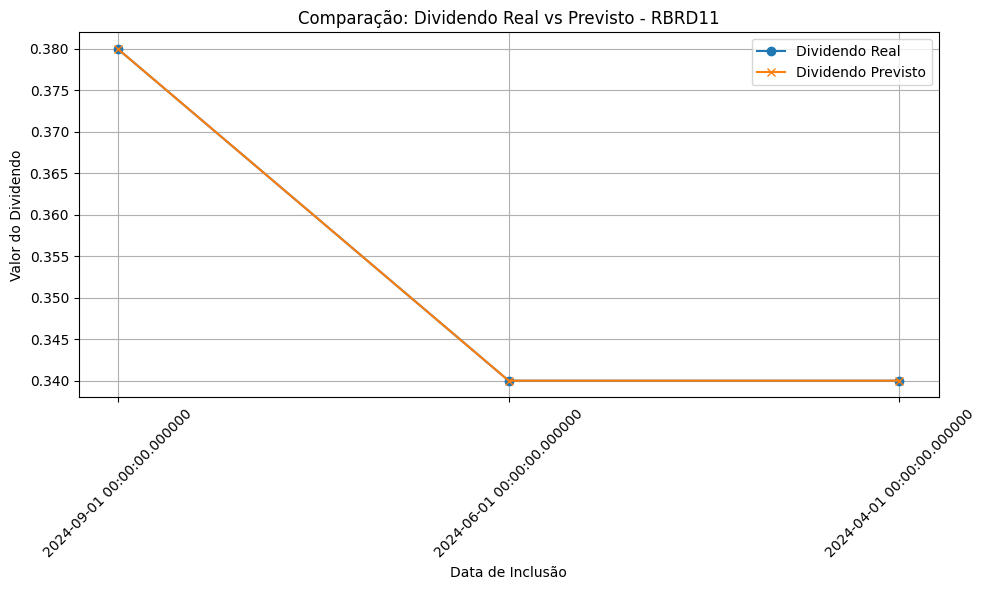

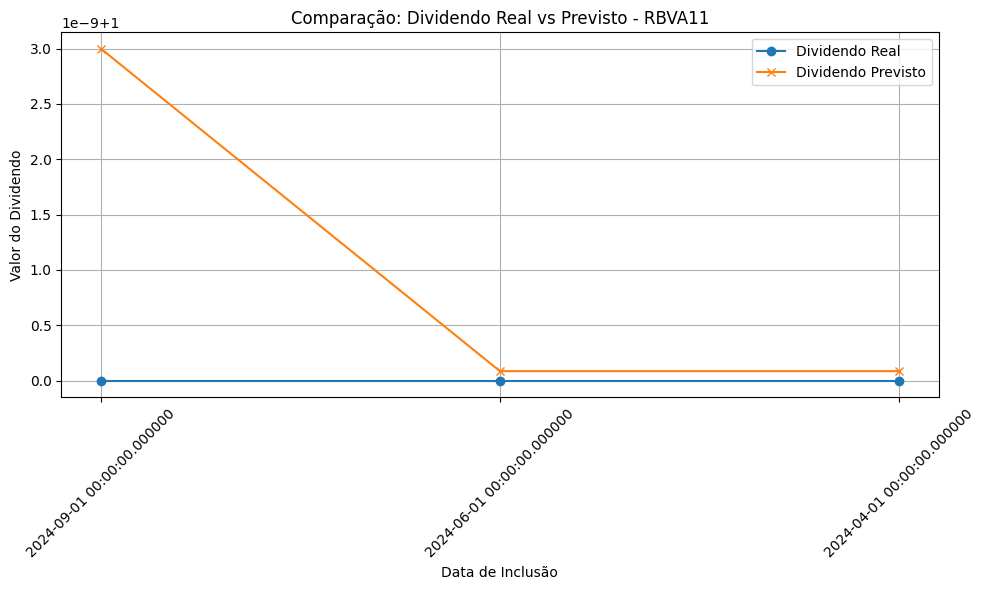

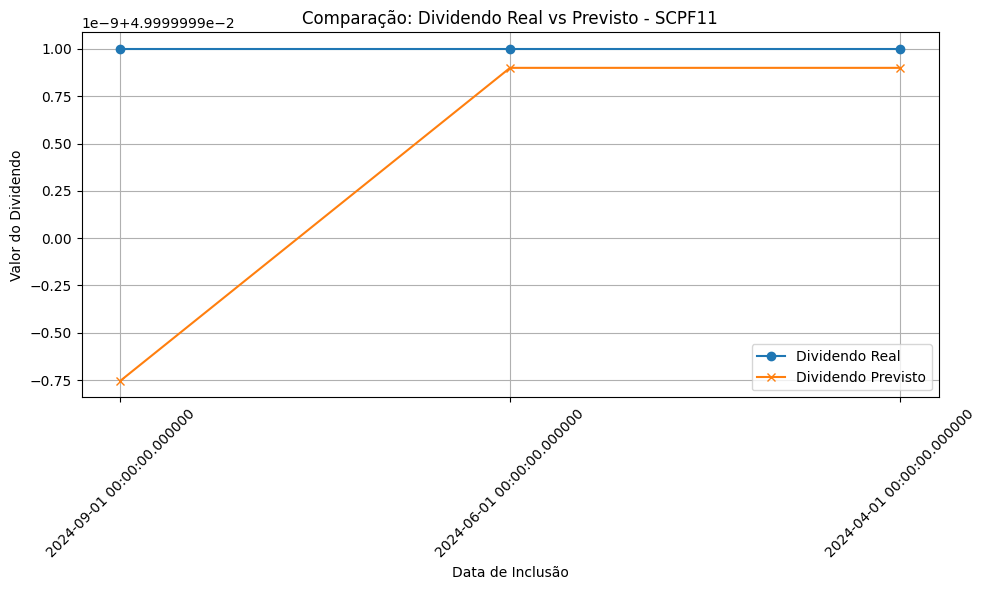

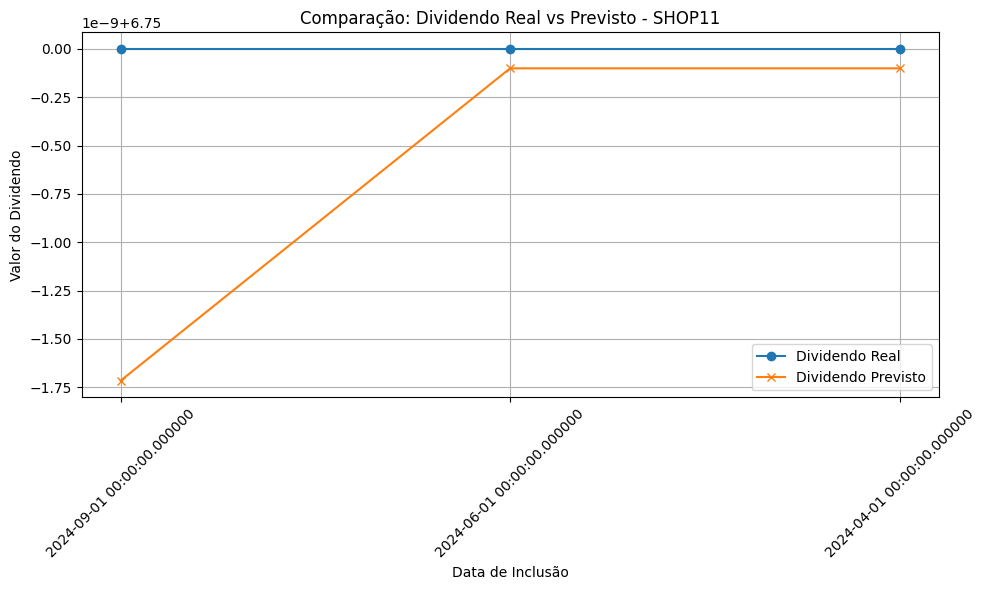

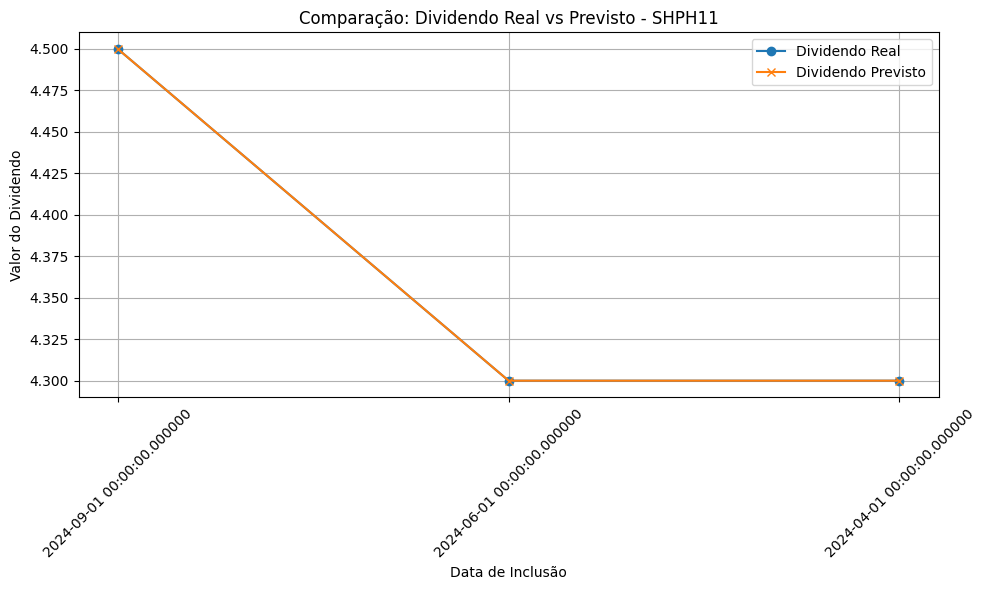

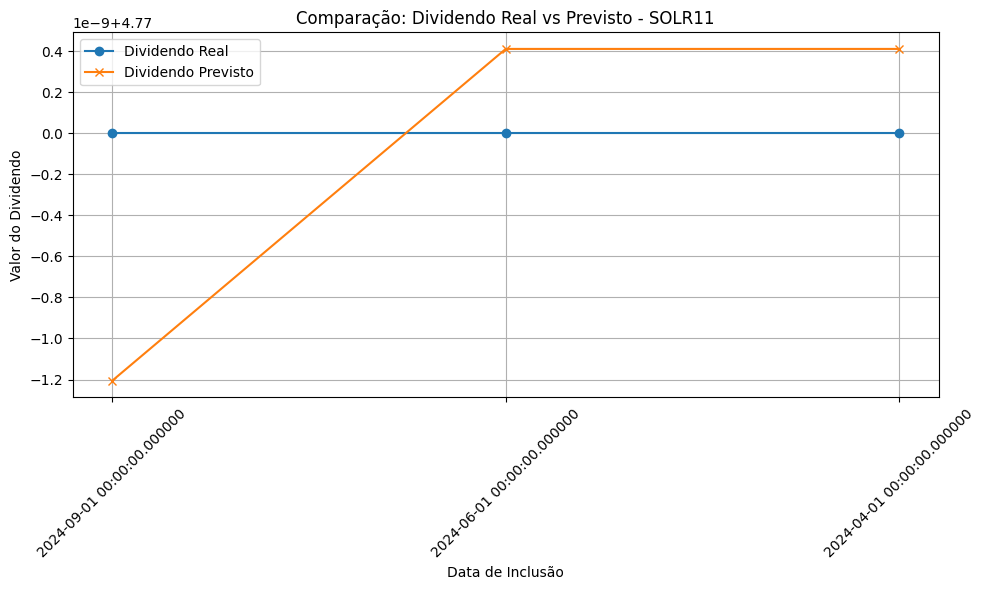

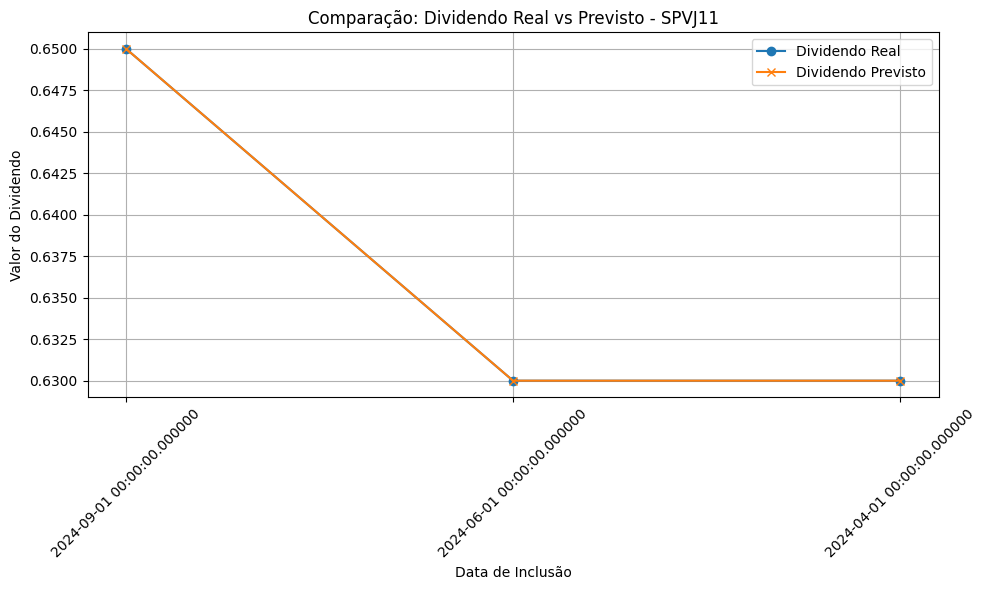

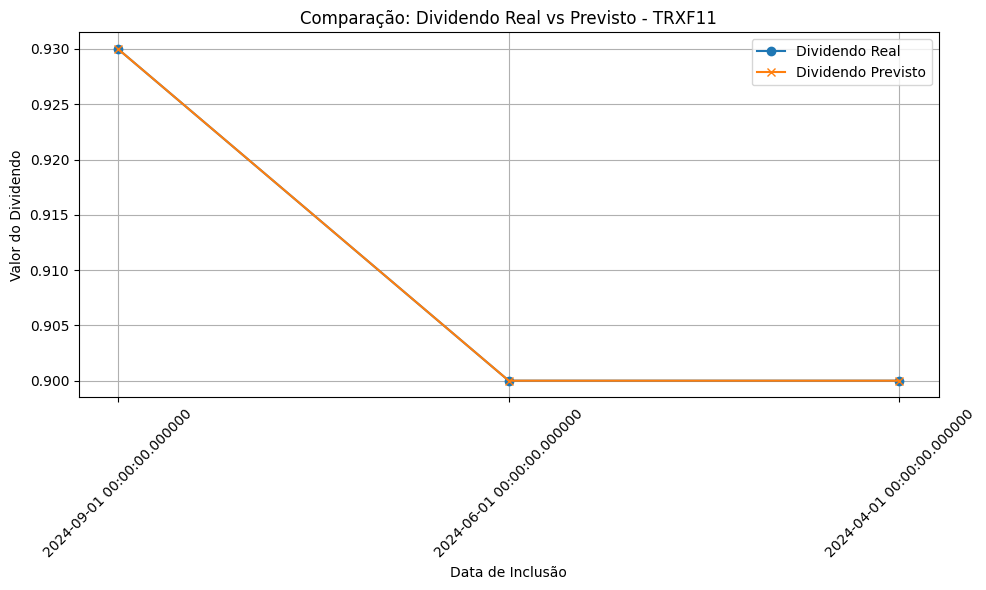

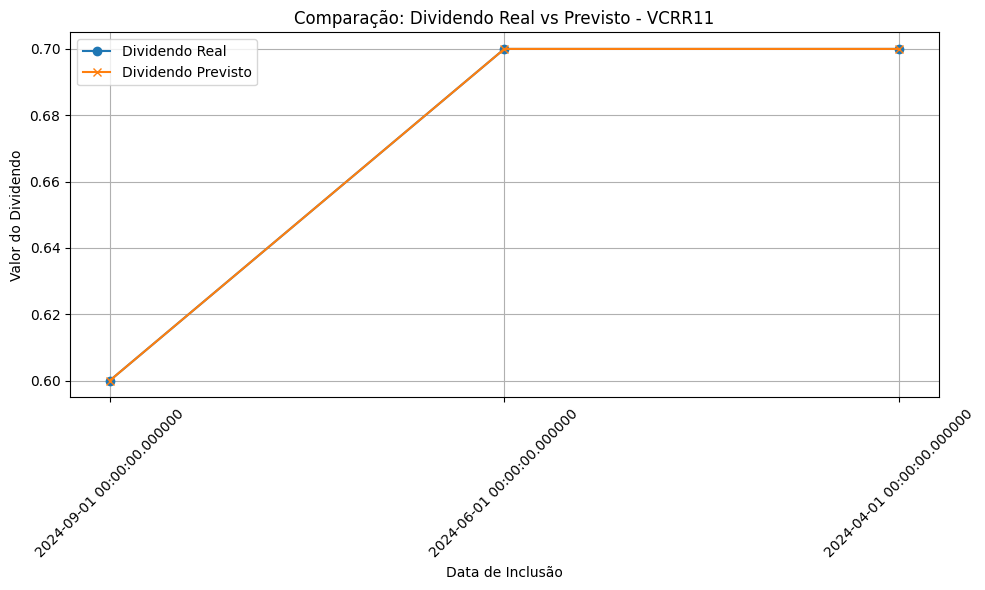

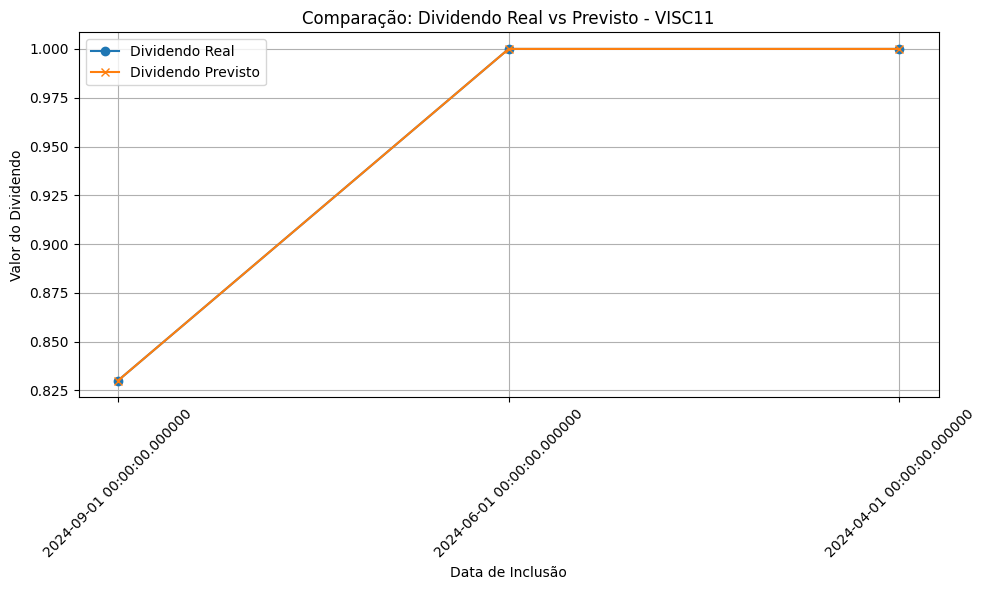

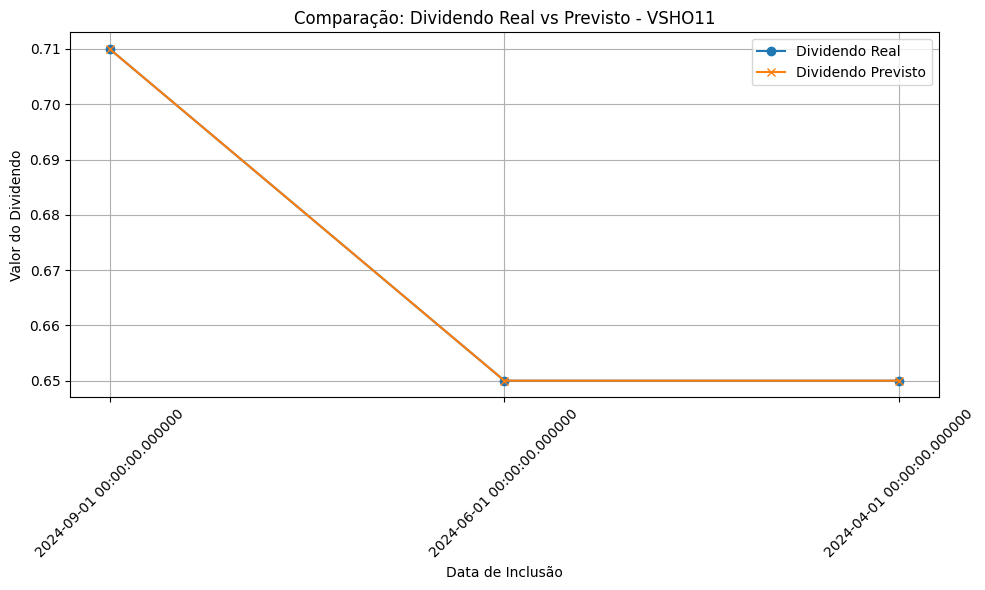

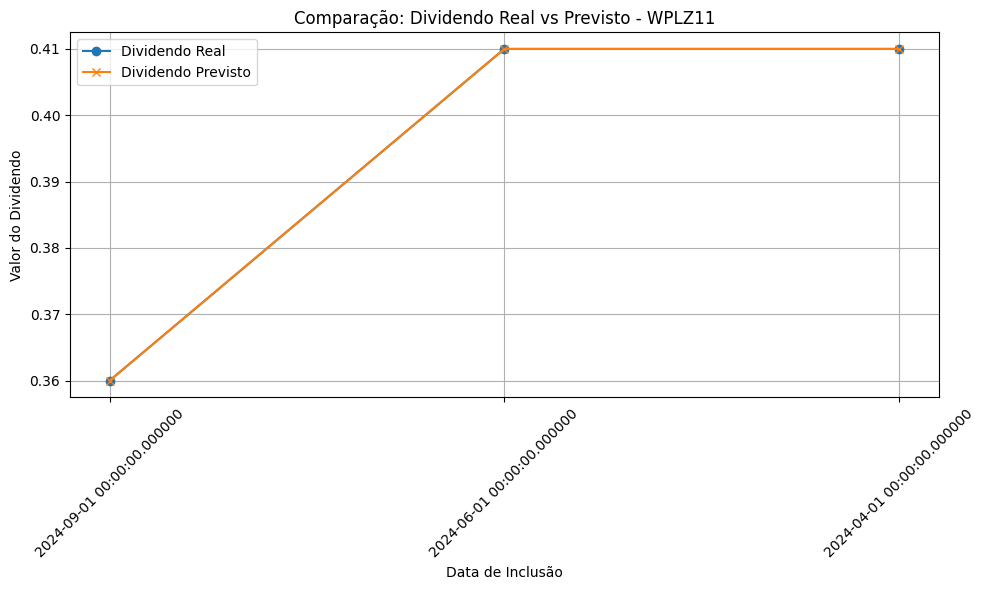

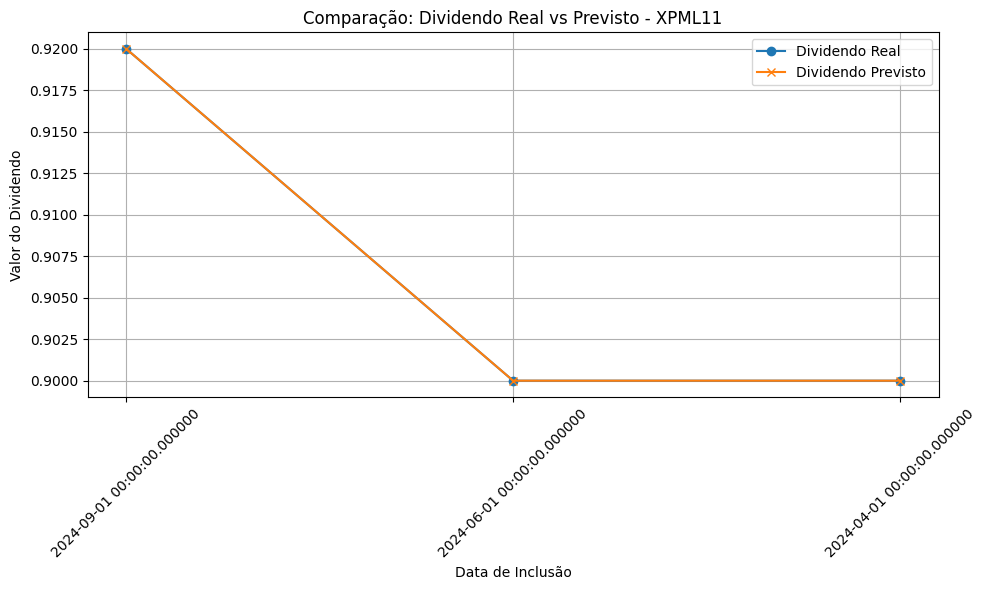

In [7]:
import matplotlib.pyplot as plt

# Obter a lista de títulos únicos
titulos_unicos = resultado['nm_titulo'].unique()

# Iterar sobre cada título e criar um gráfico
for titulo in titulos_unicos:
    # Filtrar os dados para o título atual
    resultado_filtrado = resultado[(resultado['nm_titulo'] == titulo) & (resultado['dt_inclusao'] >= '2024-04-01')]

    # Criando o gráfico de linha
    plt.figure(figsize=(10, 6))

    # Plotando os valores reais de vl_dividendo
    plt.plot(resultado_filtrado['dt_inclusao'], resultado_filtrado['vl_dividendo'], label='Dividendo Real', marker='o')

    # Plotando os valores previstos de vl_dividendo_previsto
    plt.plot(resultado_filtrado['dt_inclusao'], resultado_filtrado['vl_dividendo_previsto'], label='Dividendo Previsto', marker='x')

    # Configurações adicionais do gráfico
    plt.title(f'Comparação: Dividendo Real vs Previsto - {titulo}')
    plt.xlabel('Data de Inclusão')
    plt.ylabel('Valor do Dividendo')
    plt.xticks(rotation=45)  # Rotaciona as datas para melhor visualização
    plt.legend()
    plt.grid(True)

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()

### Interface Simulação

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Função para executar trade com otimizações e observações
def executar_trade_optimizado_com_observacoes(mes, saldo_atual, portifolio, ativos_para_comprar):
    observacoes = []

    # Vender ativos com previsão de queda nos dividendos
    ativos_para_vender = portifolio.loc[portifolio['vl_dividendo_previsto'] < portifolio['vl_dividendo']]

    # Calculando saldo após venda
    valor_venda = ativos_para_vender['valor_investido'].sum()
    saldo_atual += valor_venda

    # Atualizando portifólio removendo os ativos vendidos e marcando trade = -1 (venda)
    portifolio.loc[ativos_para_vender.index, 'trade'] = -1
    observacoes.append(f"Vendidos {len(ativos_para_vender)} ativos devido à queda na previsão de dividendos.")
    portifolio = portifolio.drop(ativos_para_vender.index)

    # Selecionar ativos para compra (evitando duplicação e garantindo diversificação)
    ativos_comprados = set(portifolio['nm_titulo'].tolist())
    novas_linhas = []

    for ativo in ativos_para_comprar.itertuples():
        if ativo.nm_titulo not in ativos_comprados and saldo_atual > 0:
            investimento = min(saldo_atual / len(ativos_para_comprar), saldo_atual)
            novas_linhas.append([ativo.nm_titulo, investimento, ativo.vl_dividendo, ativo.vl_dividendo_previsto, 1])
            saldo_atual -= investimento
            ativos_comprados.add(ativo.nm_titulo)
            observacoes.append(f"Comprado ativo {ativo.nm_titulo} devido à boa previsão de dividendos e baixa volatilidade.")

    # Adicionar observação de manutenção
    if len(novas_linhas) == 0:
        observacoes.append("Nenhum novo ativo foi comprado, mantendo o portfólio atual.")

    # Verificar e garantir que há pelo menos 6 ativos no portfólio
    while len(ativos_comprados) < 6 and saldo_atual > 0:
        for ativo in ativos_para_comprar.itertuples():
            if ativo.nm_titulo not in ativos_comprados:
                investimento = min(saldo_atual / len(ativos_para_comprar), saldo_atual)
                novas_linhas.append([ativo.nm_titulo, investimento, ativo.vl_dividendo, ativo.vl_dividendo_previsto, 1])
                saldo_atual -= investimento
                ativos_comprados.add(ativo.nm_titulo)
                observacoes.append(f"Comprado ativo {ativo.nm_titulo} para garantir diversificação.")

            if len(ativos_comprados) >= 6:
                break

    # Adicionando novas linhas de uma só vez
    if novas_linhas:
        novas_linhas_df = pd.DataFrame(novas_linhas, columns=['nm_titulo', 'valor_investido', 'vl_dividendo', 'vl_dividendo_previsto', 'trade'])
        portifolio = pd.concat([portifolio, novas_linhas_df], ignore_index=True)

    # Atualizando ativos mantidos (sem alterações) para trade = 0
    portifolio.loc[portifolio['trade'].isna(), 'trade'] = 0

    return portifolio, saldo_atual, observacoes

# Função otimizada para rodar o processo de investimento com observações
def simular_investimento_optimizado_com_observacoes(saldo_inicial, meses_investimento):
    saldo = saldo_inicial
    portifolio = pd.DataFrame(columns=['nm_titulo', 'valor_investido', 'vl_dividendo', 'vl_dividendo_previsto', 'trade'])
    historico_observacoes = []

    # Pré-selecionar ativos conservadores uma vez
    ativos_ordenados = test.sort_values(by=['vl_volatility_lag1',
                                            'vl_media_taxa_homicidios',
                                            'vl_avaliacao_media_ativos_fundo',
                                            'vl_liquidez_media_diaria',
                                            'vl_pvp'], ascending=True).head(20)

    for mes in pd.date_range('2024-10-01', periods=meses_investimento, freq='MS'):
        # Filtrar ativos disponíveis até a data do mês
        ativos_mes = ativos_ordenados[ativos_ordenados['dt_inclusao'] < mes]

        # Executar trade e obter observações
        portifolio, saldo, observacoes = executar_trade_optimizado_com_observacoes(mes, saldo, portifolio, ativos_mes)

        # Atualizando saldo com os dividendos recebidos
        dividendos_recebidos = (portifolio['vl_dividendo_previsto'] * portifolio['valor_investido']).sum()
        saldo += dividendos_recebidos

        # Adicionar observações ao histórico
        historico_observacoes.append({
            'mes': mes.strftime('%Y-%m'),
            'saldo': saldo,
            'observacoes': observacoes,
            'portifolio': portifolio.copy()
        })

    return saldo, historico_observacoes

# Configurando Dash
app = dash.Dash(__name__)

# Layout da aplicação
app.layout = html.Div([
    html.H1("Simulação de Investimentos"),

    dcc.Input(id="saldo_inicial", type="number", placeholder="Saldo Inicial (R$)", value=10000),
    dcc.Input(id="meses_investimento", type="number", placeholder="Meses de Investimento", value=12),

    html.Button('Rodar Simulação', id='run_simulation', n_clicks=0),

    dcc.Graph(id="saldo_graph"),
    dcc.Graph(id="portfolio_graph"),

    html.Div(id="observacoes")
])

# Callback para atualizar a simulação
@app.callback(
    [Output("saldo_graph", "figure"), Output("portfolio_graph", "figure"), Output("observacoes", "children")],
    [Input("run_simulation", "n_clicks")],
    [Input("saldo_inicial", "value"), Input("meses_investimento", "value")]
)
def update_simulation(n_clicks, saldo_inicial, meses_investimento):
    if n_clicks > 0:
        # Executar a simulação
        saldo_final, historico_observacoes = simular_investimento_optimizado_com_observacoes(saldo_inicial, meses_investimento)

        # Gráfico de saldo ao longo dos meses
        saldos = [obs['saldo'] for obs in historico_observacoes]
        meses = [obs['mes'] for obs in historico_observacoes]
        saldo_fig = px.line(x=meses, y=saldos, labels={'x': 'Mês', 'y': 'Saldo (R$)'}, title="Evolução do Saldo")

        # Gráfico do portfólio
        ultimo_portifolio = historico_observacoes[-1]['portifolio']
        portfolio_fig = px.bar(ultimo_portifolio, x='nm_titulo', y='valor_investido', title="Distribuição do Portfólio")

        # Exibir observações do último mês
        observacoes_html = [html.H4(f"Observações do mês {historico_observacoes[-1]['mes']}")]
        observacoes_html += [html.P(obs) for obs in historico_observacoes[-1]['observacoes']]

        return saldo_fig, portfolio_fig, observacoes_html
    return {}, {}, ""

# Rodar o app
if __name__ == "__main__":
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

### Simulação

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Função para exibir seções formatadas
def exibir_secao(titulo):
    print("\n" + "=" * 50)
    print(f"{titulo.center(50)}")
    print("=" * 50)

# Função para formatar a exibição do portfólio
def exibir_portfolio(portifolio):
    print("\n" + "-" * 50)
    print(f"{'Ativo'.ljust(20)}{'Investimento(R$)'.ljust(15)}{'Trade'.rjust(10)}")
    print("-" * 50)

    for index, row in portifolio.iterrows():
        print(f"{row['nm_titulo'].ljust(20)}{str(round(row['valor_investido'], 2)).ljust(15)}{str(int(row['trade'])).rjust(10)}")
    print("-" * 50)

# Função para executar trade com otimizações e observações
def executar_trade_optimizado_com_observacoes(mes, saldo_atual, portifolio, ativos_para_comprar):
    observacoes = []

    # Vender ativos com previsão de queda nos dividendos
    ativos_para_vender = portifolio.loc[portifolio['vl_dividendo_previsto'] < portifolio['vl_dividendo']]

    # Calculando saldo após venda
    valor_venda = ativos_para_vender['valor_investido'].sum()
    saldo_atual += valor_venda

    # Atualizando portifólio removendo os ativos vendidos e marcando trade = -1 (venda)
    portifolio.loc[ativos_para_vender.index, 'trade'] = -1
    observacoes.append(f"Vendidos {len(ativos_para_vender)} ativos devido à queda na previsão de dividendos.")
    portifolio = portifolio.drop(ativos_para_vender.index)

    # Selecionar ativos para compra (evitando duplicação e garantindo diversificação)
    ativos_comprados = set(portifolio['nm_titulo'].tolist())
    novas_linhas = []

    for ativo in ativos_para_comprar.itertuples():
        if ativo.nm_titulo not in ativos_comprados and saldo_atual > 0:
            investimento = min(saldo_atual / len(ativos_para_comprar), saldo_atual)
            novas_linhas.append([ativo.nm_titulo, investimento, ativo.vl_dividendo, ativo.vl_dividendo_previsto, 1])
            saldo_atual -= investimento
            ativos_comprados.add(ativo.nm_titulo)
            observacoes.append(f"Comprado ativo {ativo.nm_titulo} devido à boa previsão de dividendos e baixa volatilidade.")

    # Adicionar observação de manutenção
    if len(novas_linhas) == 0:
        observacoes.append("Nenhum novo ativo foi comprado, mantendo o portfólio atual.")

    # Verificar e garantir que há pelo menos 6 ativos no portfólio
    while len(ativos_comprados) < 6 and saldo_atual > 0:
        for ativo in ativos_para_comprar.itertuples():
            if ativo.nm_titulo not in ativos_comprados:
                investimento = min(saldo_atual / len(ativos_para_comprar), saldo_atual)
                novas_linhas.append([ativo.nm_titulo, investimento, ativo.vl_dividendo, ativo.vl_dividendo_previsto, 1])
                saldo_atual -= investimento
                ativos_comprados.add(ativo.nm_titulo)
                observacoes.append(f"Comprado ativo {ativo.nm_titulo} para garantir diversificação.")

            if len(ativos_comprados) >= 6:
                break

    # Adicionando novas linhas de uma só vez
    if novas_linhas:
        novas_linhas_df = pd.DataFrame(novas_linhas, columns=['nm_titulo', 'valor_investido', 'vl_dividendo', 'vl_dividendo_previsto', 'trade'])
        portifolio = pd.concat([portifolio, novas_linhas_df], ignore_index=True)

    # Atualizando ativos mantidos (sem alterações) para trade = 0
    portifolio.loc[portifolio['trade'].isna(), 'trade'] = 0

    return portifolio, saldo_atual, observacoes

# Função otimizada para rodar o processo de investimento com observações
def simular_investimento_optimizado_com_observacoes(saldo_inicial, meses_investimento):
    saldo = saldo_inicial
    portifolio = pd.DataFrame(columns=['nm_titulo', 'valor_investido', 'vl_dividendo', 'vl_dividendo_previsto', 'trade'])

    # Pré-selecionar ativos conservadores uma vez
    ativos_ordenados = test.sort_values(by=['vl_volatility',
                                            'vl_media_taxa_homicidios',
                                            'vl_avaliacao_media_ativos_fundo',
                                            'vl_liquidez_media_diaria',
                                            'vl_pvp'], ascending=True).head(20)

    for mes in pd.date_range('2024-10-01', periods=meses_investimento, freq='MS'):
        exibir_secao(f"Simulação para o Mês: {mes.strftime('%Y-%m')}")

        ativos_ordenados['dt_inclusao'] = pd.to_datetime(ativos_ordenados['dt_inclusao'])

        # Filtrar ativos disponíveis até a data do mês
        ativos_mes = ativos_ordenados[ativos_ordenados['dt_inclusao'] < mes]

        # Executar trade e obter observações
        portifolio, saldo, observacoes = executar_trade_optimizado_com_observacoes(mes, saldo, portifolio, ativos_mes)

        # Atualizando saldo com os dividendos recebidos
        dividendos_recebidos = (portifolio['vl_dividendo_previsto'] * portifolio['valor_investido']).sum()
        saldo += dividendos_recebidos

        # Exibir saldo atual formatado
        exibir_secao(f"Saldo Atual: R$ {saldo:.2f}")

        # Exibir o portfólio atual com formatação melhorada
        exibir_secao("Portfólio Atual:")
        exibir_portfolio(portifolio)

        # Exibir observações do mês
        exibir_secao("Observações do Mês:")
        for observacao in observacoes:
            print(f"- {observacao}")

    # Exibir saldo final após o período de investimento
    exibir_secao(f"Saldo Final após {meses_investimento} meses: R$ {saldo:.2f}")
    return saldo

# Entrada de dados pelo usuário
saldo_inicial = float(input("Quanto você quer investir inicialmente (em reais)? "))
meses_investimento = int(input("Por quantos meses você deseja investir? "))

# Separar dados em treino e teste
train = gora[gora['dt_inclusao'] < '2024-04-01']
test = gora[gora['dt_inclusao'] >= '2024-04-01']

# Features (variáveis explicativas) e target (variável de saída)
X_train = train[['vl_valor','vl_liquidez_media_diaria','vl_dividendo','vl_patrimonio','vl_volatility','vl_numero_cotista']]
y_train = train['vl_dividendo']

X_test = test[['vl_valor','vl_liquidez_media_diaria','vl_dividendo','vl_patrimonio','vl_volatility','vl_numero_cotista']]
y_test = test['vl_dividendo']

# Criando e treinando o modelo
model = LinearRegression()
model.fit(X_train, y_train)


# Previsões
test['vl_dividendo_previsto'] = model.predict(X_test)

# Rodar simulação com otimizações e observações
saldo_final = simular_investimento_optimizado_com_observacoes(saldo_inicial, meses_investimento)

Quanto você quer investir inicialmente (em reais)? 50
Por quantos meses você deseja investir? 2

          Simulação para o Mês: 2024-10           

             Saldo Atual: R$ 1928.71              

                 Portfólio Atual:                 

--------------------------------------------------
Ativo               Investimento(R$)     Trade
--------------------------------------------------
DLMT11              2.5                     1
HGRS11              2.38                    1
SPVJ11              2.26                    1
ICNE11              2.14                    1
ERCR11              2.04                    1
DAMT11B             1.93                    1
HPDP11              1.84                    1
APXM11              1.75                    1
--------------------------------------------------

               Observações do Mês:                
- Vendidos 0 ativos devido à queda na previsão de dividendos.
- Comprado ativo DLMT11 devido à boa previsão de dividendos e bai

<ipython-input-13-5d1363ff4cda>:140: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-5d1363ff4cda>:69: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

